# Домашнее задание 3

У вас есть данные о полетах. Для каждого клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета. 

Для некоторых клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied). По этим данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, для которых ответ неизвестен.

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

Продуктивной и интересной вам работы!

![image.png](attachment:./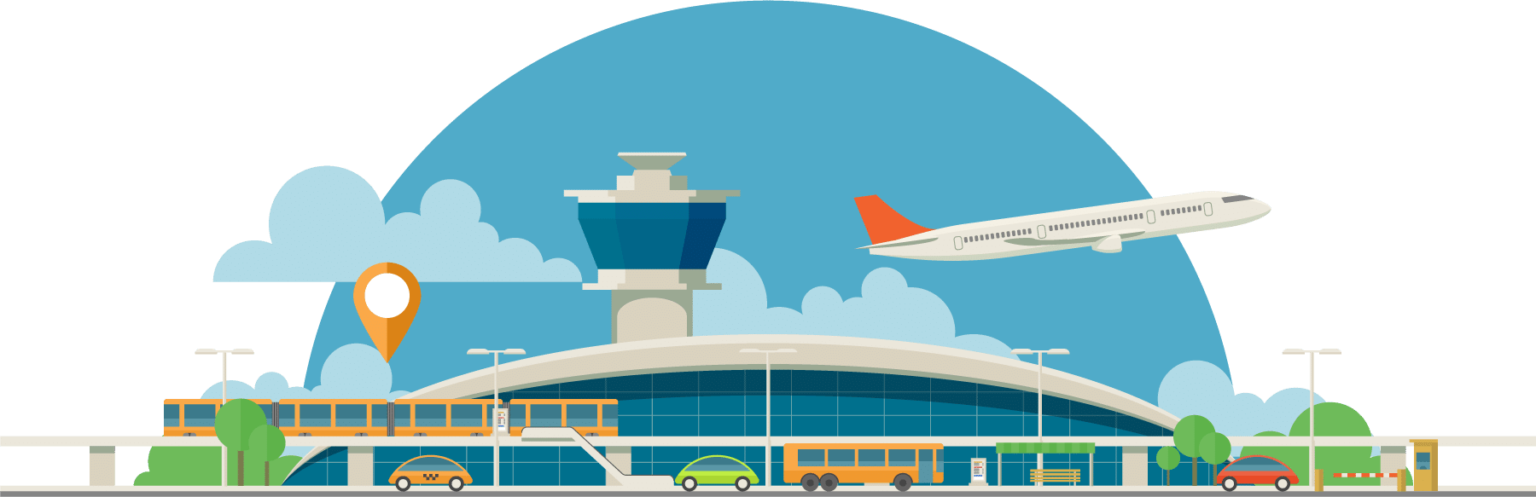)

> Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода. <br/> А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, -- текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

Брать код из открытых источников позволительно. Следование культуре цитирования при этом обязательно

In [1]:
!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm
!pip install seaborn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 7.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 24.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for lime: filename=lime-0.2.0.1-py3-no

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions 
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

# Data Prep & EDA (3 балла)

## Загрузка и предобработка данных (1.75 балла)

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-12-29 14:38:36--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/home/datalore/.postgresql/root.crt’

/home/datalore/.pos 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-12-29 14:38:36 (1.23 GB/s) - ‘/home/datalore/.postgresql/root.crt’ saved [3579/3579]



(0.5 балла) <font color='#9933CC'>Подключитесь к БД при помощи `psycopg2.connect()` и напишите SQL-запрос, объединяющий 3 нужные таблицы в одну</font>.
Список столбцов таблиц добудьте самостоятельно. 

<font color='#9933CC'>Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'</font>

> Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

### Параметры соединения
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

### Схема БД

![screens.png](attachment:./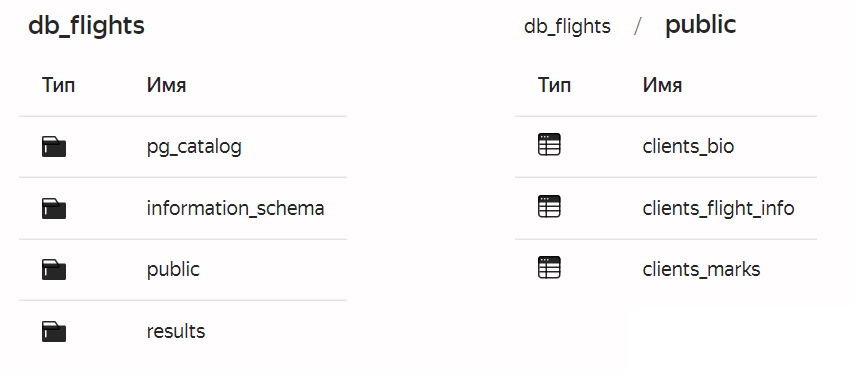)

In [4]:
conn = psycopg2.connect(
    " host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net port=6432 sslmode=verify-full dbname=db_flights user=mlhs_student password=mlhs_student target_session_attrs=read-write")
conn.set_session(autocommit=True)
cur = conn.cursor()

In [5]:
db_cols = dict()
cur.execute("SELECT column_name FROM information_schema.columns WHERE table_name = 'clients_bio'")
db_cols["clients_bio"] = [x[0] for x in cur.fetchall()]

cur.execute("SELECT column_name FROM information_schema.columns WHERE table_name = 'clients_flight_info'")
db_cols["clients_flight_info"] = [x[0] for x in cur.fetchall()]

cur.execute("SELECT column_name FROM information_schema.columns WHERE table_name = 'clients_marks'")
db_cols["clients_marks"] = [x[0] for x in cur.fetchall()]

In [6]:
def cat_query_cols(all_cols: list, table_name: str, exclude_cols: list) -> str:
    query_pattern = '{table_name}."{col_name}", '
    query_cols = ""
    for col in all_cols:
        if col not in exclude_cols:
            query_cols += query_pattern.format(table_name=table_name, col_name=col)
    return query_cols.rstrip("'")

In [7]:
selected_cols = ""
selected_cols += cat_query_cols(db_cols["clients_bio"], "clients_bio", [])
selected_cols += cat_query_cols(db_cols["clients_flight_info"], "clients_flight_info", ["id"])
selected_cols += cat_query_cols(db_cols["clients_marks"], "clients_marks", ["id"])
selected_cols = selected_cols.rstrip(", ")

In [8]:
cur.execute("""
SELECT {selected_cols}
FROM clients_bio
INNER JOIN clients_flight_info ON clients_bio.id = clients_flight_info.id
INNER JOIN clients_marks ON clients_bio.id = clients_marks.id
""".format(selected_cols=selected_cols))

In [9]:
cols = [cols for cols in list(db_cols.values())]
flat_cols = list()
for col_names in cols:
    for col_name in col_names:
        if col_name not in flat_cols:
            flat_cols.append(col_name)

df = pd.DataFrame(cur.fetchall(), columns=flat_cols).set_index("id")

In [10]:
assert df.shape == (129_549, 23)

(0.25 балла) <font color='#9933CC'>Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129549 non-null  object
 1   age                                129549 non-null  object
 2   Customer Type                      129549 non-null  object
 3   Type of Travel                     129549 non-null  object
 4   class                              129549 non-null  object
 5   Flight Distance                    129549 non-null  object
 6   Departure Delay in Minutes         129549 non-null  object
 7   Arrival Delay in Minutes           129549 non-null  object
 8   Inflight wifi service              129549 non-null  object
 9   Departure/Arrival time convenient  129549 non-null  object
 10  Ease of Online booking             129549 non-null  object
 11  Gate location                      129549 non-null  

In [12]:
for col in df.columns:
    print(f"{col}: {df[col].unique()}\n")

gender: ['Male' 'Female']

age: ['43.0' '24.0' '61.0' '35.0' '46.0' '36.0' '70.0' '7.0' '51.0' '40.0'
 '66.0' '28.0' '45.0' '54.0' '17.0' '56.0' '42.0' '60.0' '69.0' '30.0'
 '58.0' '53.0' '16.0' '39.0' '26.0' '59.0' '44.0' '33.0' '49.0' '41.0'
 '48.0' '34.0' '32.0' '52.0' '57.0' '47.0' '55.0' '23.0' '50.0' '22.0'
 '27.0' '20.0' '63.0' '15.0' '25.0' '62.0' '29.0' '37.0' '71.0' '18.0'
 '38.0' '13.0' '14.0' '31.0' '9.0' '68.0' '21.0' '19.0' '96.0' '64.0'
 'nan' '65.0' '11.0' '12.0' '67.0' '8.0' '10.0' '72.0' '77.0' '76.0'
 '177.0' '147.0' '80.0' '100.0' '85.0' '75.0' '441.0' '79.0' '272.0'
 '73.0' '78.0' '196.0' '82.0' '0.0' '102.0' '74.0' '112.0' '420.0' '230.0'
 '328.0' '200.0' '138.0' '225.0' '156.0' '344.0' '224.0' '352.0' '128.0'
 '92.0' '117.0' '324.0' '144.0' '464.0' '275.0' '232.0' '228.0' '396.0'
 '245.0' '399.0' '282.0' '240.0' '368.0' '315.0' '285.0' '312.0' '164.0'
 '220.0' '105.0' '152.0' '222.0' '192.0' '104.0' '448.0' '88.0' '300.0'
 '207.0' '195.0' '301.0' '408.0' '212.0' 

In [13]:
df = df.replace(('nan', "-"), np.nan)

In [14]:
df = df.apply(lambda x: pd.to_numeric(x, downcast="float", errors="ignore"))

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float32
 2   Customer Type                      129472 non-null  object 
 3   Type of Travel                     129448 non-null  object 
 4   class                              129433 non-null  object 
 5   Flight Distance                    129455 non-null  float32
 6   Departure Delay in Minutes         129442 non-null  float32
 7   Arrival Delay in Minutes           129042 non-null  float32
 8   Inflight wifi service              129505 non-null  float32
 9   Departure/Arrival time convenient  129500 non-null  float32
 10  Ease of Online booking             129506 non-null  float32
 11  Gate location                      1295

In [16]:
df.isna().sum() # Пропуски

gender 0
age 315
Customer Type 77
Type of Travel 101
class 116
Flight Distance 94
Departure Delay in Minutes 107
Arrival Delay in Minutes 507
Inflight wifi service 44
Departure/Arrival time convenient 49
Ease of Online booking 43
Gate location 37
Food and drink 50
Online boarding 46
Seat comfort 47
Inflight entertainment 45
On-board service 44
Leg room service 46
Baggage handling 48
Checkin service 42
Inflight service 63
cleanliness 37
satisfaction 25905
dtype: int64

In [17]:
print("Количество выбросов в числовых колонках:")
for col in df.select_dtypes("float").columns:
    q99 = df[col].quantile(0.99)
    q001 = df[col].quantile(0.01)
    print(f"{col}: {len(df[df[col] > q99][col]) + len(df[df[col] < q001][col])}")

Количество выбросов в числовых колонках:
age: 1809
Flight Distance: 2323
Departure Delay in Minutes: 1291
Arrival Delay in Minutes: 1271
Inflight wifi service: 34
Departure/Arrival time convenient: 39
Ease of Online booking: 30
Gate location: 44
Food and drink: 169
Online boarding: 34
Seat comfort: 49
Inflight entertainment: 49
On-board service: 37
Leg room service: 643
Baggage handling: 35
Checkin service: 44
Inflight service: 49
cleanliness: 47


(0.5 балла) <font color='#9933CC'>Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме</font>

Нас интересует `matrix` пропущенных значений и столбцатая диаграмма в логарифмированной шкале (*пропусков немного => по обычной не будет видно, в каких столбцах их больше*)

<Axes: >

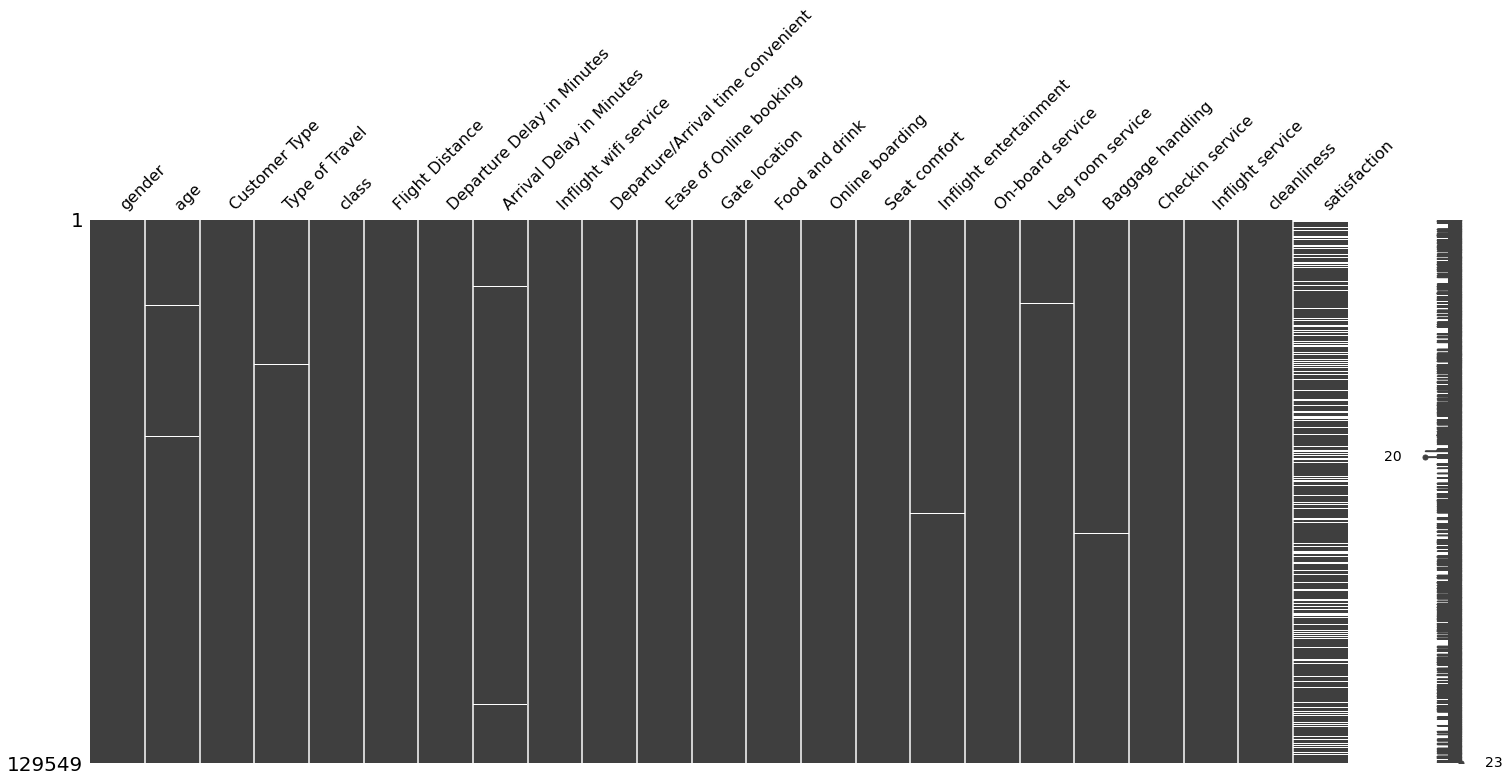

In [18]:
missingno.matrix(df)

FixedFormatter should only be used together with FixedLocator


<Axes: >

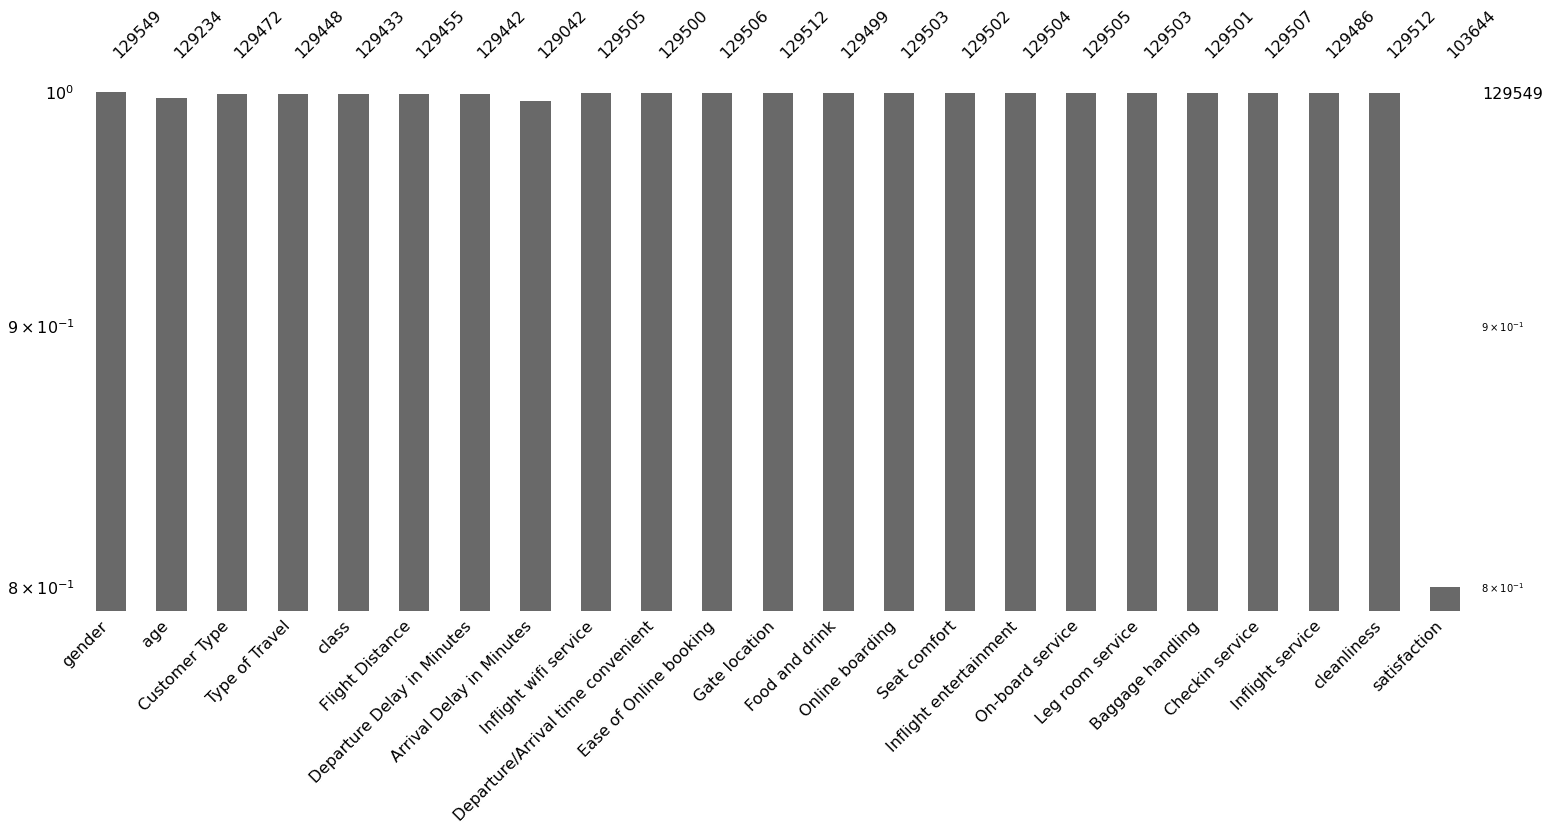

In [19]:
missingno.bar(df, log=True)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [20]:
df_train = df[df.satisfaction.notna()]
df_train

gender 
 age 
 Customer Type 
 Type of Travel 
 class 
 Flight Distance 
 Departure Delay in Minutes 
 Arrival Delay in Minutes 
 Inflight wifi service 
 Departure/Arrival time convenient 
 ... 
 Online boarding 
 Seat comfort 
 Inflight entertainment 
 On-board service 
 Leg room service 
 Baggage handling 
 Checkin service 
 Inflight service 
 cleanliness 
 satisfaction 
 
 
 id 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 7 
 Male 
 43.0 
 Loyal Customer 
 Business travel 
 Business 
 1963.0 
 0.0 
 0.0 
 3.0 
 3.0 
 ... 
 4.0 
 5.0 
 5.0 
 5.0 
 5.0 
 5.0 
 4.0 
 5.0 
 4.0 
 satisfied 
 
 
 13 
 Male 
 24.0 
 disloyal Customer 
 Business travel 
 Eco 
 453.0 
 16.0 
 30.0 
 2.0 
 2.0 
 ... 
 2.0 
 5.0 
 5.0 
 2.0 
 4.0 
 4.0 
 2.0 
 4.0 
 5.0 
 neutral or dissatisfied 
 
 
 18 
 Female 
 61.0 
 Loyal Customer 
 Personal Travel 
 Eco 
 821.0 
 0.0 
 0.0 
 2.0 
 5.0 
 ... 
 1.0 
 5.0 
 5.0 
 5.0 
 2.0 
 5.0 
 5.0 
 5.0 
 1.0 
 neutral or dissatisfied 
 
 
 31 
 Male 
 35.0 
 disloyal Customer 
 Business travel 
 Business 
 212.0 
 0.0 
 0.0 
 2.0 
 2.0 
 ... 
 2.0 
 2.0 
 2.0 
 4.0 
 5.0 
 5.0 
 5.0 
 4.0 
 2.0 
 neutral or dissatisfied 
 
 
 39 
 Female 
 46.0 
 Loyal Customer 
 Business travel 
 Business 
 67.0 
 0.0 
 0.0 
 3.0 
 3.0 
 ... 
 5.0 
 4.0 
 4.0 
 4.0 
 4.0 
 4.0 
 5.0 
 4.0 
 5.0 
 satisfied 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 129831 
 Female 
 28.0 
 Loyal Customer 
 Personal Travel 
 Eco 
 447.0 
 23.0 
 16.0 
 1.0 
 3.0 
 ... 
 1.0 
 3.0 
 3.0 
 1.0 
 1.0 
 4.0 
 1.0 
 5.0 
 3.0 
 neutral or dissatisfied 
 
 
 129837 
 Male 
 66.0 
 Loyal Customer 
 Personal Travel 
 Eco 
 337.0 
 199.0 
 213.0 
 2.0 
 4.0 
 ... 
 5.0 
 5.0 
 5.0 
 2.0 
 4.0 
 5.0 
 5.0 
 4.0 
 5.0 
 neutral or dissatisfied 
 
 
 129838 
 Female 
 59.0 
 Loyal Customer 
 Personal Travel 
 Eco 
 308.0 
 32.0 
 24.0 
 3.0 
 5.0 
 ... 
 5.0 
 5.0 
 3.0 
 3.0 
 3.0 
 3.0 
 4.0 
 3.0 
 4.0 
 neutral or dissatisfied 
 
 
 129839 
 Male 
 61.0 
 Loyal Customer 
 Personal Travel 
 Eco 
 337.0 
 0.0 
 0.0 
 2.0 
 4.0 
 ... 
 2.0 
 3.0 
 3.0 
 4.0 
 5.0 
 5.0 
 5.0 
 4.0 
 3.0 
 neutral or dissatisfied 
 
 
 129846 
 Male 
 44.0 
 Loyal Customer 
 Personal Travel 
 Eco 
 447.0 
 0.0 
 0.0 
 2.0 
 5.0 
 ... 
 2.0 
 5.0 
 5.0 
 4.0 
 2.0 
 4.0 
 3.0 
 4.0 
 5.0 
 neutral or dissatisfied 
 
 
 
 103644 rows × 23 columns

In [21]:
assert df_train.shape == (103_644, 23)

In [22]:
df_test = df[df.satisfaction.isna()].drop('satisfaction', axis=1)
df_test

gender 
 age 
 Customer Type 
 Type of Travel 
 class 
 Flight Distance 
 Departure Delay in Minutes 
 Arrival Delay in Minutes 
 Inflight wifi service 
 Departure/Arrival time convenient 
 ... 
 Food and drink 
 Online boarding 
 Seat comfort 
 Inflight entertainment 
 On-board service 
 Leg room service 
 Baggage handling 
 Checkin service 
 Inflight service 
 cleanliness 
 
 
 id 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 55 
 Male 
 36.0 
 Loyal Customer 
 Business travel 
 Business 
 3655.0 
 40.0 
 71.0 
 1.0 
 1.0 
 ... 
 1.0 
 3.0 
 3.0 
 3.0 
 3.0 
 3.0 
 1.0 
 4.0 
 3.0 
 2.0 
 
 
 79 
 Female 
 70.0 
 Loyal Customer 
 Personal Travel 
 Eco 
 108.0 
 50.0 
 41.0 
 5.0 
 4.0 
 ... 
 4.0 
 4.0 
 4.0 
 3.0 
 3.0 
 0.0 
 3.0 
 5.0 
 3.0 
 5.0 
 
 
 126 
 Male 
 66.0 
 Loyal Customer 
 Personal Travel 
 Eco 
 562.0 
 88.0 
 84.0 
 2.0 
 5.0 
 ... 
 5.0 
 2.0 
 5.0 
 5.0 
 3.0 
 5.0 
 2.0 
 5.0 
 5.0 
 5.0 
 
 
 199 
 Female 
 60.0 
 Loyal Customer 
 Business travel 
 Business 
 3756.0 
 36.0 
 24.0 
 4.0 
 4.0 
 ... 
 2.0 
 4.0 
 5.0 
 4.0 
 4.0 
 4.0 
 4.0 
 5.0 
 4.0 
 5.0 
 
 
 263 
 Male 
 43.0 
 Loyal Customer 
 Personal Travel 
 Business 
 802.0 
 0.0 
 0.0 
 1.0 
 2.0 
 ... 
 2.0 
 3.0 
 3.0 
 2.0 
 2.0 
 1.0 
 2.0 
 3.0 
 2.0 
 1.0 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 129750 
 Male 
 38.0 
 Loyal Customer 
 Business travel 
 Eco 
 337.0 
 92.0 
 82.0 
 4.0 
 3.0 
 ... 
 4.0 
 5.0 
 4.0 
 4.0 
 4.0 
 5.0 
 4.0 
 5.0 
 3.0 
 4.0 
 
 
 129771 
 Male 
 16.0 
 Loyal Customer 
 Personal Travel 
 Eco 
 308.0 
 2.0 
 0.0 
 3.0 
 4.0 
 ... 
 1.0 
 3.0 
 5.0 
 1.0 
 4.0 
 2.0 
 5.0 
 5.0 
 4.0 
 1.0 
 
 
 129798 
 Female 
 43.0 
 Loyal Customer 
 Personal Travel 
 Eco 
 308.0 
 0.0 
 0.0 
 2.0 
 4.0 
 ... 
 3.0 
 5.0 
 5.0 
 4.0 
 4.0 
 2.0 
 4.0 
 4.0 
 4.0 
 5.0 
 
 
 129868 
 Male 
 47.0 
 Loyal Customer 
 Business travel 
 Eco Plus 
 447.0 
 0.0 
 0.0 
 3.0 
 4.0 
 ... 
 4.0 
 3.0 
 4.0 
 4.0 
 2.0 
 5.0 
 3.0 
 1.0 
 4.0 
 4.0 
 
 
 129876 
 Male 
 28.0 
 Loyal Customer 
 Personal Travel 
 Eco Plus 
 447.0 
 2.0 
 3.0 
 4.0 
 4.0 
 ... 
 4.0 
 4.0 
 1.0 
 4.0 
 5.0 
 4.0 
 4.0 
 4.0 
 5.0 
 4.0 
 
 
 
 25905 rows × 22 columns

In [23]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [152]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [25]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

(0.25 балла) <font color='#9933CC'>Заполните пропуски в данных наиболее часто встречающимся значением</font>.
Обратите внимание, что правильная стратегия заполнения пропусков выглядит так:

* посчитать моды для `X_train`
* ими заполнить пропуски в `X_train`, `X_val` и `df_test`

Было бы неплохо воспользоваться другой стратегией: восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Но для признаков в нашей задаче они в чистом виде бы, увы, скорее, не подошли. Импьютеры возвращали бы вещественные значения, а в нашей задаче все признаки целые. 

В общем, для изящного и удобного для применения в пайплайне заполнения пропусков, пришлось бы кодить самописные классы. Этим можете заняться в бонусной части.

In [153]:
train_modes = X_train.mode().T.to_dict()[0]

In [154]:
X_train = X_train.fillna(value=train_modes)
X_val = X_val.fillna(value=train_modes)
df_test = df_test.fillna(value=train_modes)

<font color='#9933CC'>Выведите основные статистики по числовым и категориальным столбцам таблицы `X_train`</font>

In [28]:
X_train.describe(include="all")

gender 
 age 
 Customer Type 
 Type of Travel 
 class 
 Flight Distance 
 Departure Delay in Minutes 
 Arrival Delay in Minutes 
 Inflight wifi service 
 Departure/Arrival time convenient 
 ... 
 Food and drink 
 Online boarding 
 Seat comfort 
 Inflight entertainment 
 On-board service 
 Leg room service 
 Baggage handling 
 Checkin service 
 Inflight service 
 cleanliness 
 
 
 
 
 count 
 72550 
 72550.000000 
 72550 
 72550 
 72550 
 72550.000000 
 72550.000000 
 72550.000000 
 72550.000000 
 72550.000000 
 ... 
 72550.000000 
 72550.000000 
 72550.000000 
 72550.000000 
 72550.000000 
 72550.000000 
 72550.000000 
 72550.000000 
 72550.000000 
 72550.000000 
 
 
 unique 
 2 
 NaN 
 2 
 2 
 3 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 ... 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 top 
 Female 
 NaN 
 Loyal Customer 
 Business travel 
 Business 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 ... 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 freq 
 36816 
 NaN 
 59406 
 50054 
 34793 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 ... 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 mean 
 NaN 
 40.098854 
 NaN 
 NaN 
 NaN 
 1329.018311 
 15.859366 
 16.645967 
 2.733687 
 3.065017 
 ... 
 3.209318 
 3.256513 
 3.445665 
 3.362150 
 3.383101 
 3.352364 
 3.630255 
 3.309056 
 3.640234 
 3.291178 
 
 
 std 
 NaN 
 20.658195 
 NaN 
 NaN 
 NaN 
 4764.369629 
 70.861938 
 97.990295 
 1.362172 
 1.552254 
 ... 
 1.349963 
 1.372739 
 1.346077 
 1.360862 
 1.333758 
 1.360180 
 1.227853 
 1.293114 
 1.215114 
 1.343302 
 
 
 min 
 NaN 
 0.000000 
 NaN 
 NaN 
 NaN 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 ... 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 25% 
 NaN 
 27.000000 
 NaN 
 NaN 
 NaN 
 413.000000 
 0.000000 
 0.000000 
 2.000000 
 2.000000 
 ... 
 2.000000 
 2.000000 
 2.000000 
 2.000000 
 2.000000 
 2.000000 
 3.000000 
 3.000000 
 3.000000 
 2.000000 
 
 
 50% 
 NaN 
 40.000000 
 NaN 
 NaN 
 NaN 
 844.000000 
 0.000000 
 0.000000 
 3.000000 
 3.000000 
 ... 
 3.000000 
 3.000000 
 4.000000 
 4.000000 
 4.000000 
 4.000000 
 4.000000 
 3.000000 
 4.000000 
 3.000000 
 
 
 75% 
 NaN 
 51.000000 
 NaN 
 NaN 
 NaN 
 1744.000000 
 12.000000 
 13.000000 
 4.000000 
 4.000000 
 ... 
 4.000000 
 4.000000 
 5.000000 
 4.000000 
 4.000000 
 4.000000 
 5.000000 
 4.000000 
 5.000000 
 4.000000 
 
 
 max 
 NaN 
 544.000000 
 NaN 
 NaN 
 NaN 
 379620.000000 
 9282.000000 
 11760.000000 
 45.000000 
 45.000000 
 ... 
 36.000000 
 32.000000 
 45.000000 
 40.000000 
 45.000000 
 36.000000 
 40.000000 
 45.000000 
 36.000000 
 45.000000 
 
 
 
 11 rows × 22 columns

<font color='#FF6600'>Что вы можете сказать про распределение значений признаков?</font>

В первую очередь, видны выбросы как в большую, так и в меньшую сторону. Например, для числовых: age - 544, Flight Distance - 0, а для категориальных: Ease of Online booking - 28 баллов, Seat comfort - 45 баллов.

(0.25 балла) <font color='#9933CC'>Удалите строки c выбросами в числовых столбцах</font> (для трейна и валидации; тест оставьте без изменений). Выбросами считайте значения признака, строго превышающие 0.996-квантиль


---
<br/>

*Откуда взялся именно 0.996-квантиль?*

*В рамках анализа данных на выборсы вы вполне могли заметить, какие значения признаков встречаются редко. В среднем для всех признаков эти значения начинаются ~в этом квантиле*

In [155]:
for col in X_train.select_dtypes("float").columns:
    q_mask = X_train[col] <= X_train[col].quantile(0.996)
    X_train = X_train[q_mask]
    y_train = y_train[q_mask]

In [156]:
for col in X_val.select_dtypes("float").columns:
    q_mask = X_val[col] <= X_val[col].quantile(0.996)
    X_val = X_val[q_mask]
    y_val = y_val[q_mask]

## EDA (1.25 балла)

Создадим переменные с перечислениями столбцов разного типа

In [157]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols)) 
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [66]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

(0.5 балла) <font color='#9933CC'>Напишите процедуры для отрисовки графиков</font>

* Для признаков, которые мы выделили как порядковые, отображайте только `countplot`
* Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)
* Для категориальных -- только `countplot`

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

> Все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима

In [142]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
        plt.figure(figsize=(10, 5))
        unique_labels = np.unique(y)
        labels_order = unique_labels[np.argsort(np.unique(y))]
        sns.countplot(data=df, x=col, hue=y, hue_order=labels_order)
        plt.show()

In [143]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row 
    for all columns in 'cols' with informative title 
    """
    for col in cols:
        fig, ax = plt.subplots(1, 2, figsize=(15, 9))
        unique_labels = np.unique(y)
        labels_order = unique_labels[np.argsort(np.unique(y))]
        sns.kdeplot(data=df, x=col, hue=y, ax=ax[0], hue_order=labels_order)
        sns.boxplot(data=df, x=col, y=y, ax=ax[1], order=labels_order)
        fig.tight_layout()
        plt.show()

In [144]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
        plt.figure(figsize=(10, 5))
        unique_labels = np.unique(y)
        labels_order = unique_labels[np.argsort(np.unique(y))]
        sns.countplot(data=df, x=col, hue=y, hue_order=labels_order)
        plt.show()

<font color='#9933CC'>Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне</font>

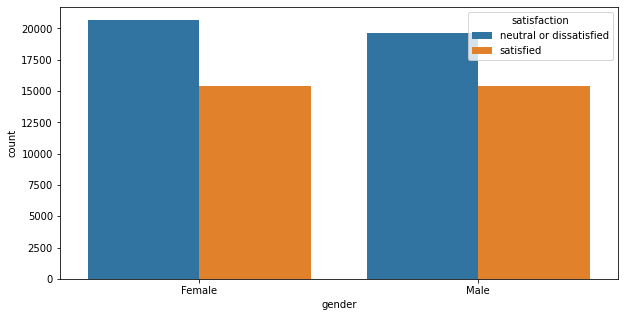

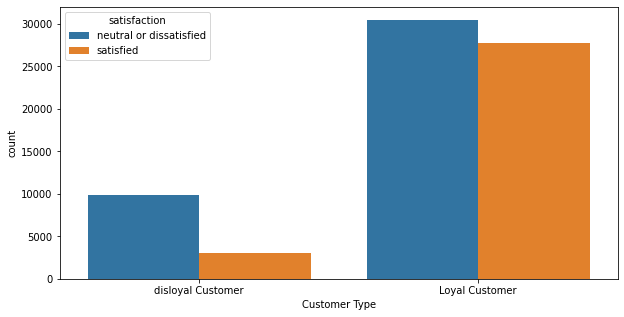

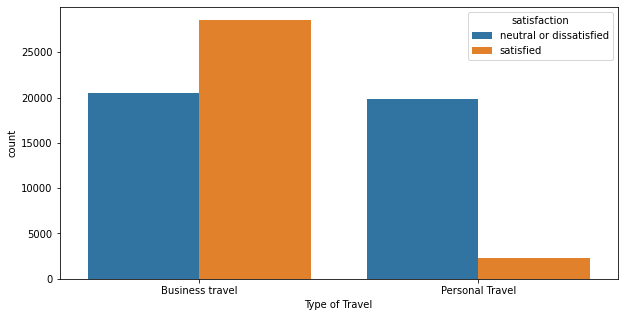

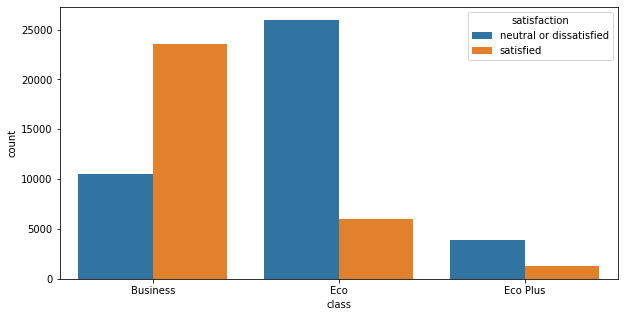

In [145]:
plot_categorical(categorical_cols, X_train, y_train)

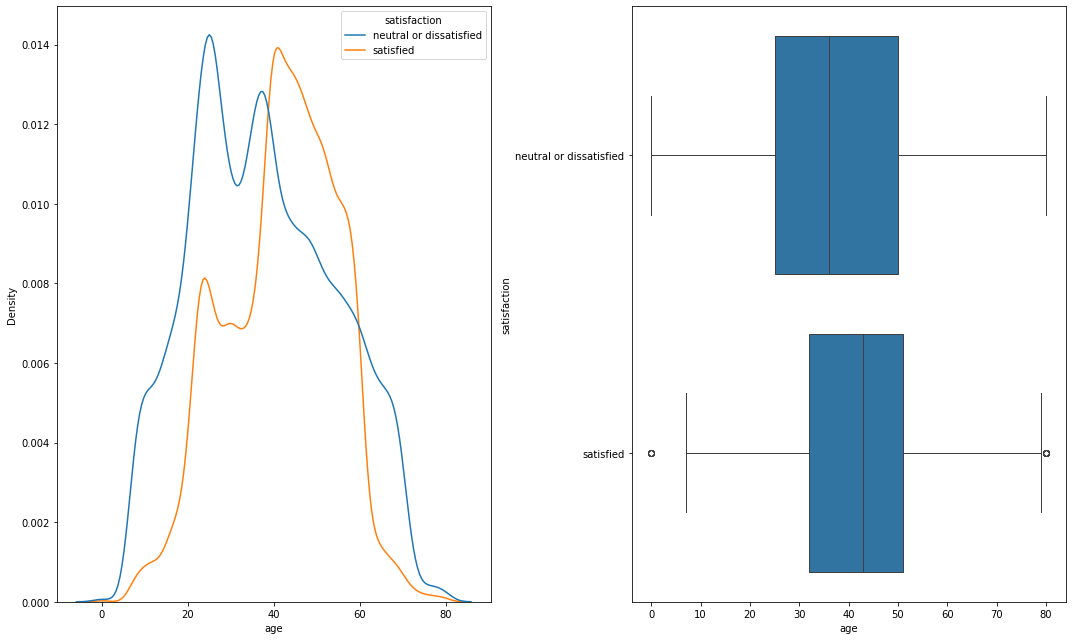

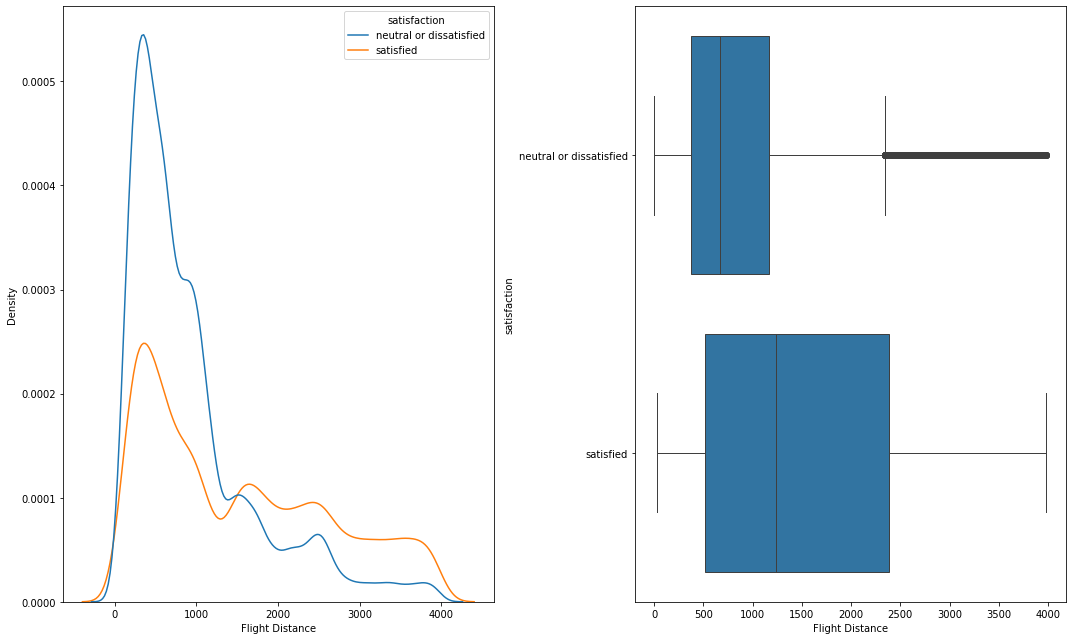

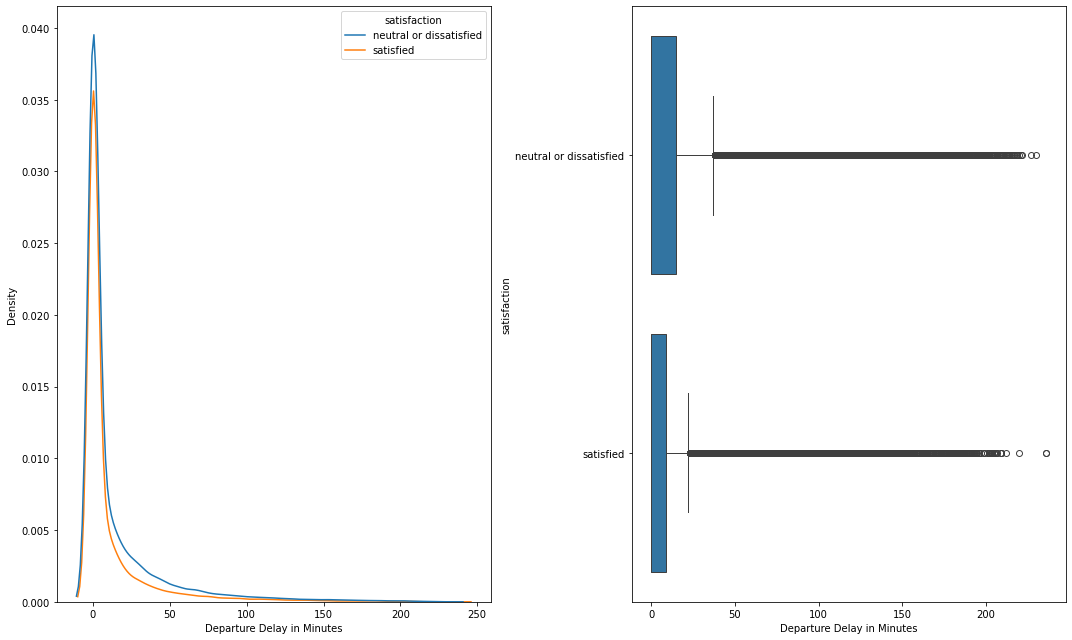

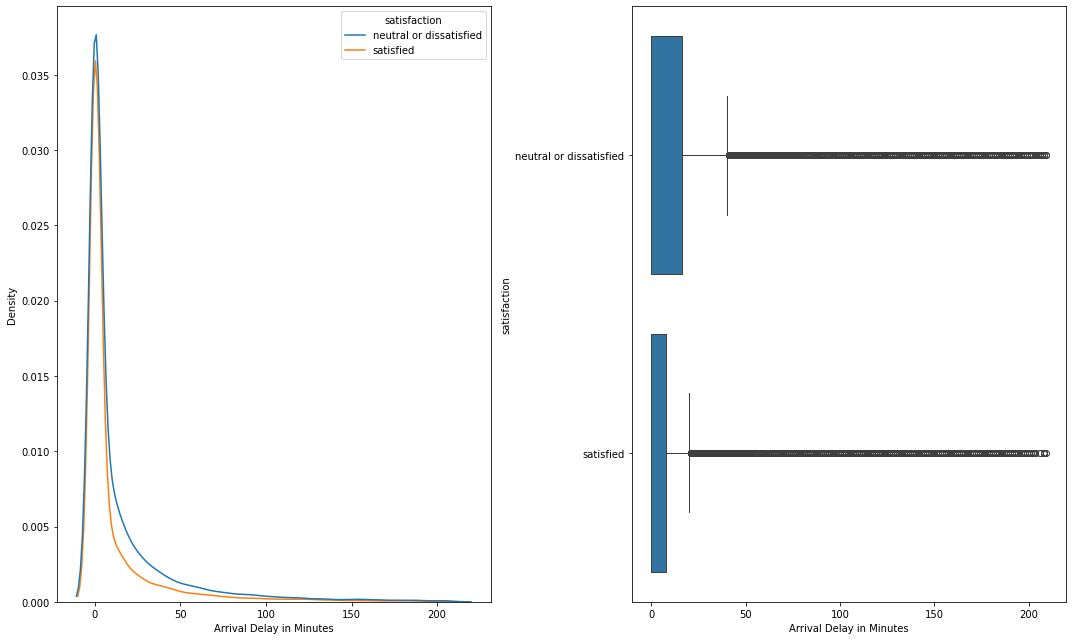

In [146]:
plot_continuous(continuous_cols, X_train, y_train)

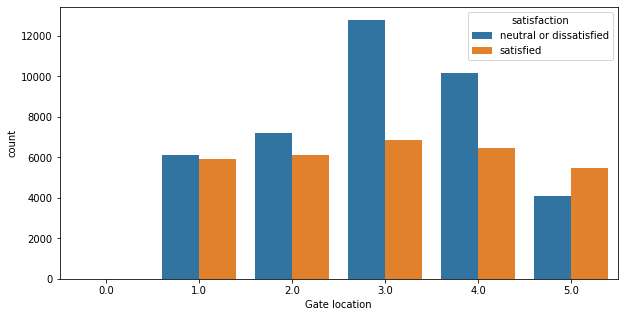

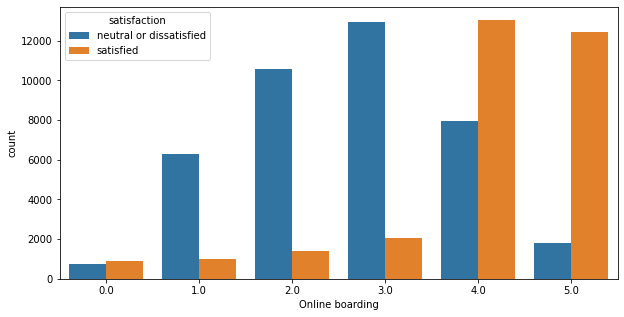

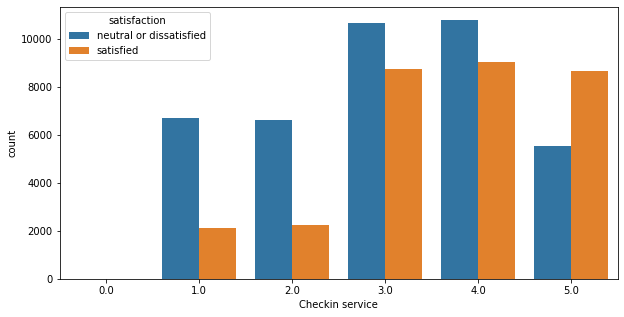

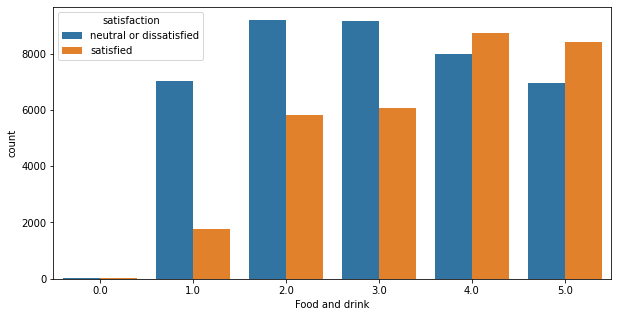

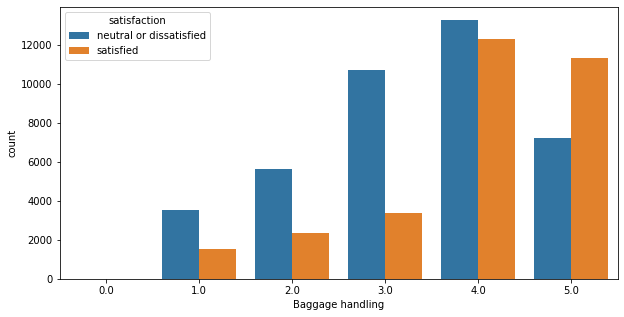

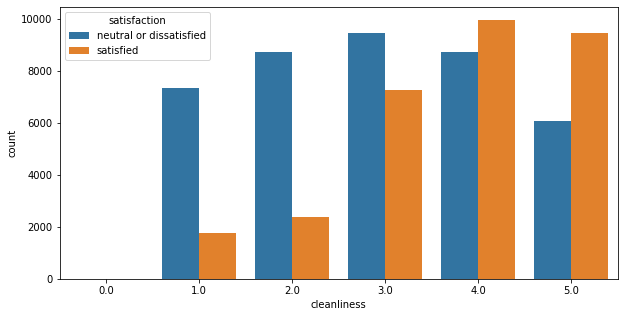

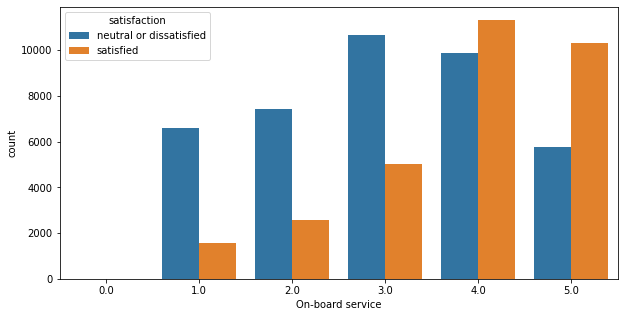

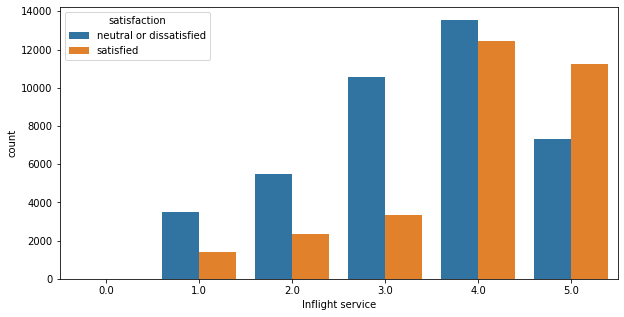

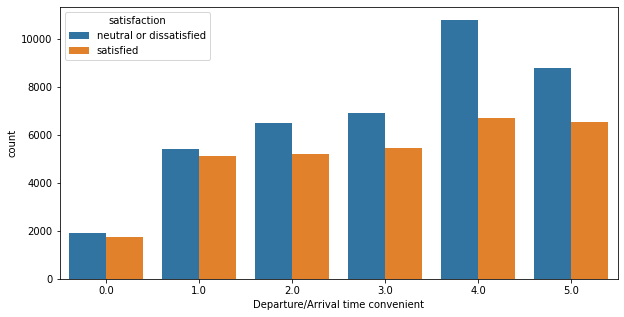

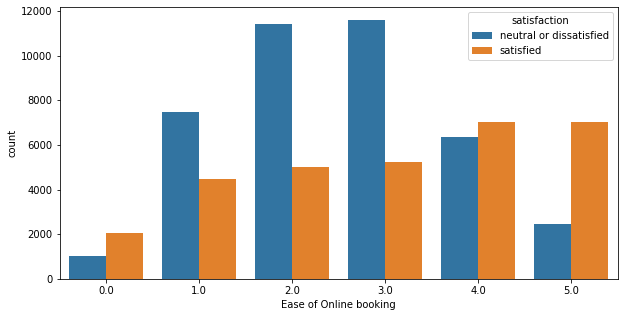

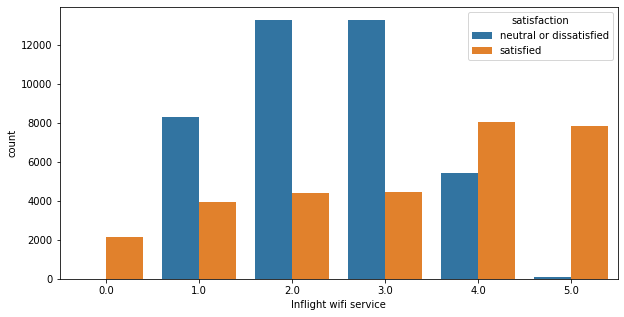

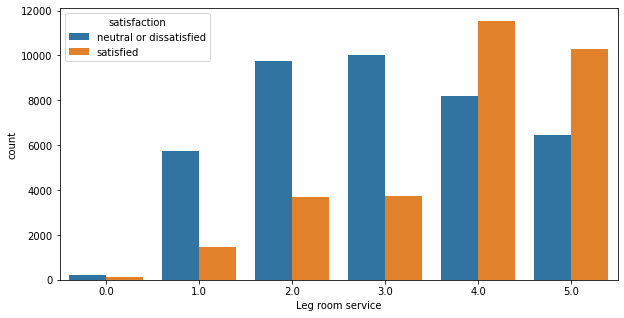

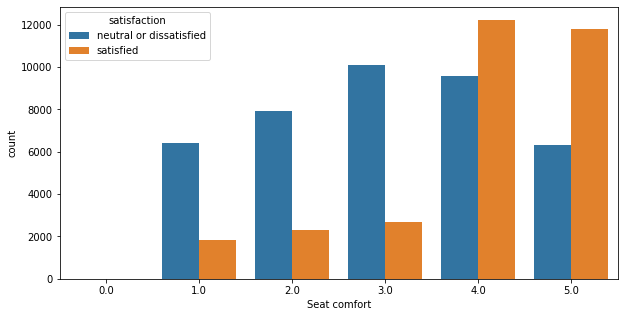

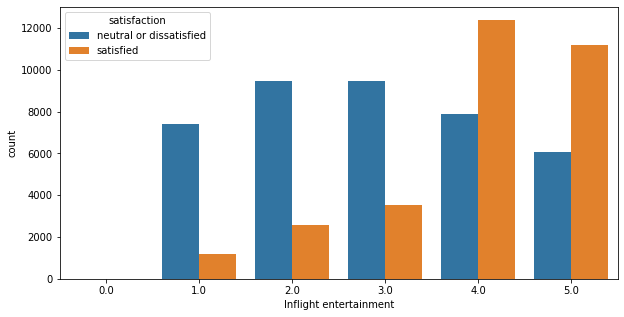

In [147]:
plot_ordinal(ordinal_cols, X_train, y_train)

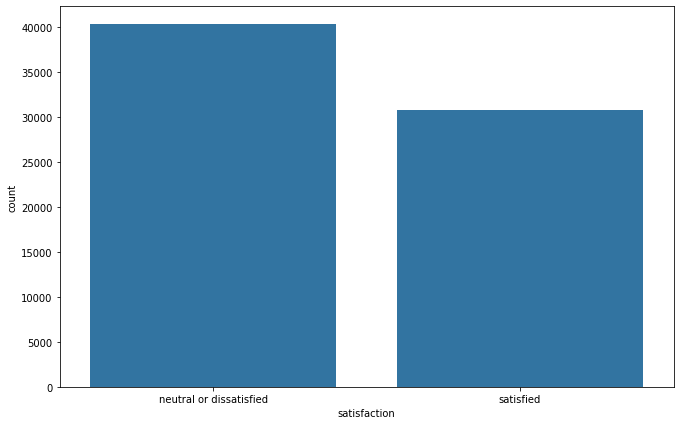

In [148]:
plt.figure(figsize=(11, 7))
sns.countplot(y_train.to_frame(), x="satisfaction")
plt.show()

<font color='#FF6600'>Сделайте выводы по построенным графикам</font>. Полезно было бы упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

- Классы достаточно сбалансированы (есть небольшой отрыв класса 'neutral or dissatisfied' по количеству). 
- Основная задача понять, насколько хорошо можно разделить классы, опираясь на признаки. Рассмотрим признаки по порядку
- Категориальные признаки:
	- `gender`: классы распределены равномерно, особых различий в зависимости от пола нет.
	- `Customer Type`: Пассажиров типа `Loyal Customer` в принципе больше, но распределение по классам внутри этого признака равномерно. Пассажиры типа `disloyal customer` склонны ставить оценку `neutral or dissatisfied`, то есть распределение неравномерно.
	- `Type of Travel`: Неравномерное распределение по классам. При типе `Personal Travel` пассажиры с большей вероятностью поставят `neutral or dissatisfied`. 
	- `class`: Ожидаемо, наиболее удовлетворены полетом пассажиры, летевшие классом `Business`, тогда как в классе `Eco` и `Eco Plus` люди остались скорее недовольны полетом.
- Континуальные признаки:
	- `age`: Распределения сильно схожи между собой, так как площадь перекрытия большая и формы распределения повторяют друг друга. Однако в диапазоне от 18 до 30 лет плотность объектов, относящихся к классу `neutral or dissatisfied` значительно выше, к тому же форма распределения `satisfied` уже. В принципе, `age` можно считать плохо разделяемым признаком.
	- `Flight Distance`: Основной объем объектов, относящихся к классу `neutral or dissatisfied` лежит в пределах межквартильного размаха для объектов класса `satisfied`, то есть пассажиры могут остаться недовольными и при полете на короткое расстояние, возможно за счет других факторов. Однако в целом, формы распределений повторяют друг друга, то есть разделяемость классов по этому признаку скорее всего будет плохой.
	- `Departure Delay in Minutes` и `Arrival Delay in Minutes`: Два вообще линейно зависимых признака, при этом распределения для обоих классов практически в точности повторяют друг друга. Признак будет плохо разделять классы.
- Порядковые признаки:
	- В целом, можно сказать, что чем выше оценка, тем с большей вероятностью количество объектов `satisfied` будет преобладать. За исключением некоторых признаков:
		- `Checkin service`: При оценке 3 или 4 распределение по классам схожее.
		- `Inflight wifi service`: Очень сильно влияет на принадлежность к классу `neutral or dissatisfied`, так как при оценке ниже 4 пассажир скорее останется недоволен.
		- `Gate location`: относительно объектов класса `satisfied` распределение скорее равномерное.
	- Предположение: 
		- Особенно объекты класса `neutral or dissatisfied` сильно не привязаны к оценке, то есть вероятно независимо от того, какая оценка может стоять за большую часть аспектов, пассажира может сильно не удовлетворить один, и окончательное решение будет принято исходя из оценки этого аспекта, так как общее впечатление от полета будет зависеть от него. Например, если `Inflight wifi service` был оценен в 2 или 3, не смотря на то, что остальные оценки, например, выше 4, то в итоге пассажир будет не удовлетворён полетом. 
- Таким образом, из категориальных предварительно можно выделить признаки: `Type of Travel`и `class`, как наиболее важные для разделения классов. Из континуальных: `Flight distance`. Из порядковых: `Inflight wifi service`, `Departure/Arrival time convenient`, `On-board service`, `Ease of Online booking`, `Online boarding`, `Seat comfort`, `Baggage handling`, `Inflight entertainment`, `Leg room service`, `Inflight service`, `cleanliness`, `food and drink` 


(Бонус: 0.25 балла) <font color='#9933CC'>По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест </font>

In [40]:
from scipy.special import rel_entr

def get_probability_df(concat_data, col_name, set_type):
    set_groups = concat_data.groupby("set")
    probs = concat_data.groupby("set")[col_name].value_counts()[set_type] / len(set_groups.get_group(set_type))
    probs = probs.to_frame().rename({col_name: "probability"}, axis=1).reset_index()
    return probs


def count_kl_rel(concat_data, col, set_name1, set_name2):
    train_prob = get_probability_df(concat_data, col, set_name1)
    val_prob = get_probability_df(concat_data, col, set_name2)
    prob = pd.merge(train_prob, val_prob, on=col, suffixes=("_train", "_val"))
    rel_score = sum(rel_entr(prob["probability_train"], prob["probability_val"]))
    return rel_score


def plot_inter_ordinal(concat_data, cols, set_type, set_name):
    for col in cols:
        rel_score = count_kl_rel(concat_data, col, "Train", set_name)
        plt.figure(figsize=(15, 13))
        sns.displot(data=concat_data, x=col, hue=set_type, stat="probability")
        plt.title(f"Расхождение К-Л: {rel_score}")
        plt.show()


def plot_inter_continuous(concat_data, cols, set_type, set_name):
    for col in cols:
        rel_score = count_kl_rel(concat_data, col, "Train", set_name)
        fig, ax = plt.subplots(1, figsize=(15, 13))
        sns.histplot(data=concat_data, x=col, hue=set_type, stat="probability", ax=ax)
        if "Delay" in col:
            ax.set_xscale("log")
        plt.title(f"Расхождение К-Л: {rel_score}")
        plt.show()


def plot_inter_categorical(concat_data, cols, set_type, set_name):
    for col in cols:
        rel_score = count_kl_rel(concat_data, col, "Train", set_name)
        plt.figure(figsize=(15, 13))
        sns.displot(data=concat_data, x=col, hue=set_type, stat="probability")
        plt.title(f"Расхождение К-Л: {rel_score}")
        plt.show()

### Сравнение train и validation

In [41]:
plot_x_train = X_train.copy()
plot_x_val = X_val.copy()

plot_x_train["set"] = "Train"
plot_x_val["set"] = "Validation"

plot_X = pd.concat([plot_x_train, plot_x_val], axis=0)

<Figure size 1080x936 with 0 Axes>

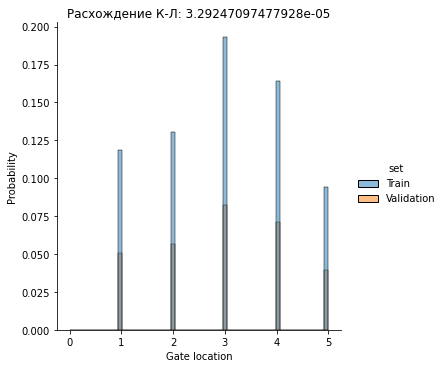

<Figure size 1080x936 with 0 Axes>

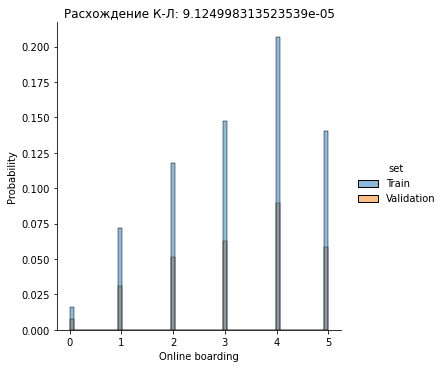

<Figure size 1080x936 with 0 Axes>

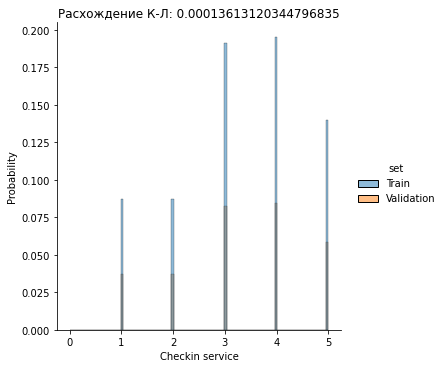

<Figure size 1080x936 with 0 Axes>

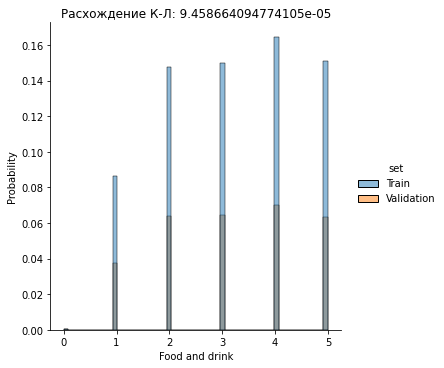

<Figure size 1080x936 with 0 Axes>

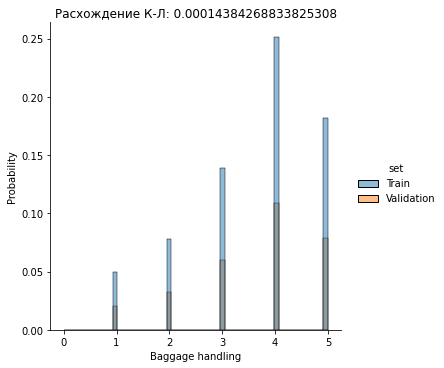

<Figure size 1080x936 with 0 Axes>

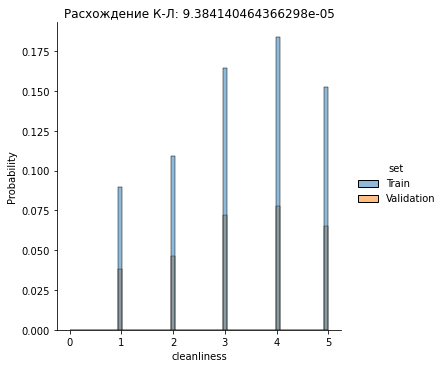

<Figure size 1080x936 with 0 Axes>

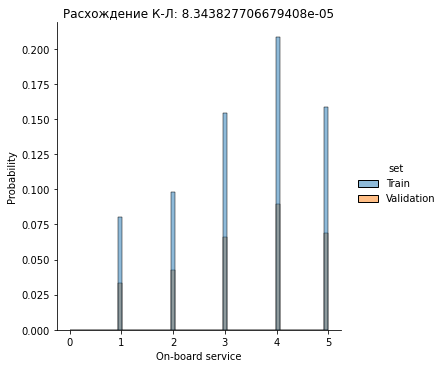

<Figure size 1080x936 with 0 Axes>

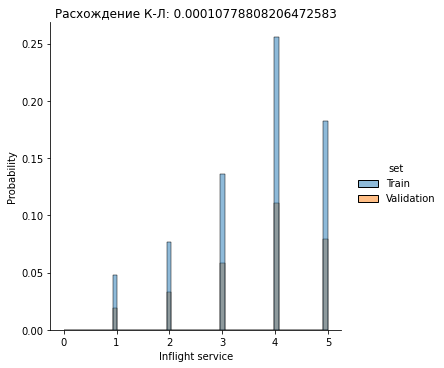

<Figure size 1080x936 with 0 Axes>

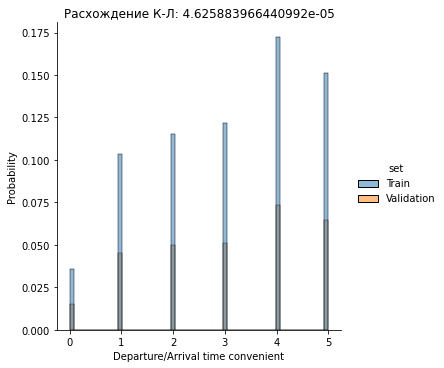

<Figure size 1080x936 with 0 Axes>

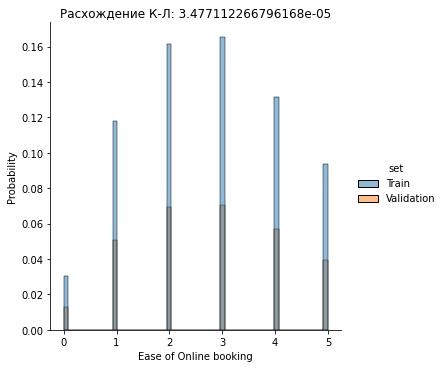

<Figure size 1080x936 with 0 Axes>

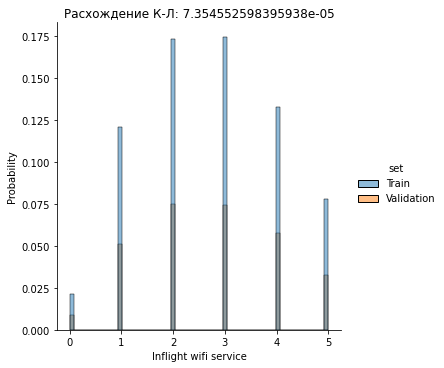

<Figure size 1080x936 with 0 Axes>

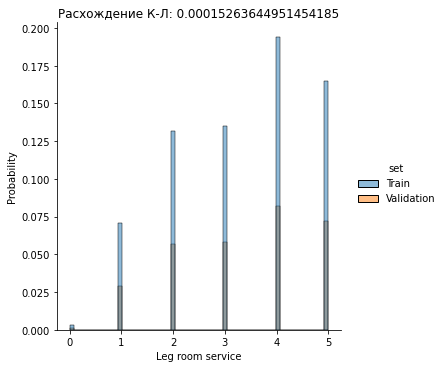

<Figure size 1080x936 with 0 Axes>

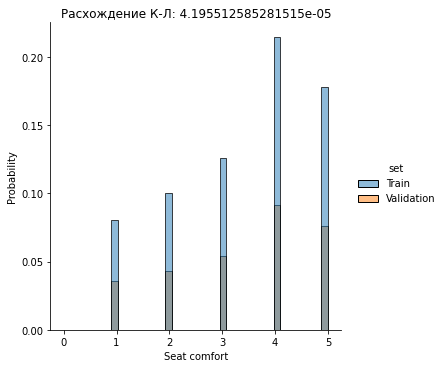

<Figure size 1080x936 with 0 Axes>

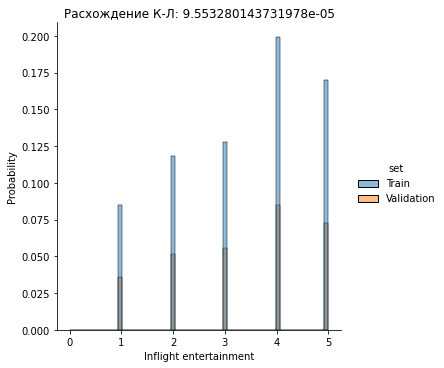

In [42]:
plot_inter_ordinal(plot_X, ordinal_cols, "set", "Validation")

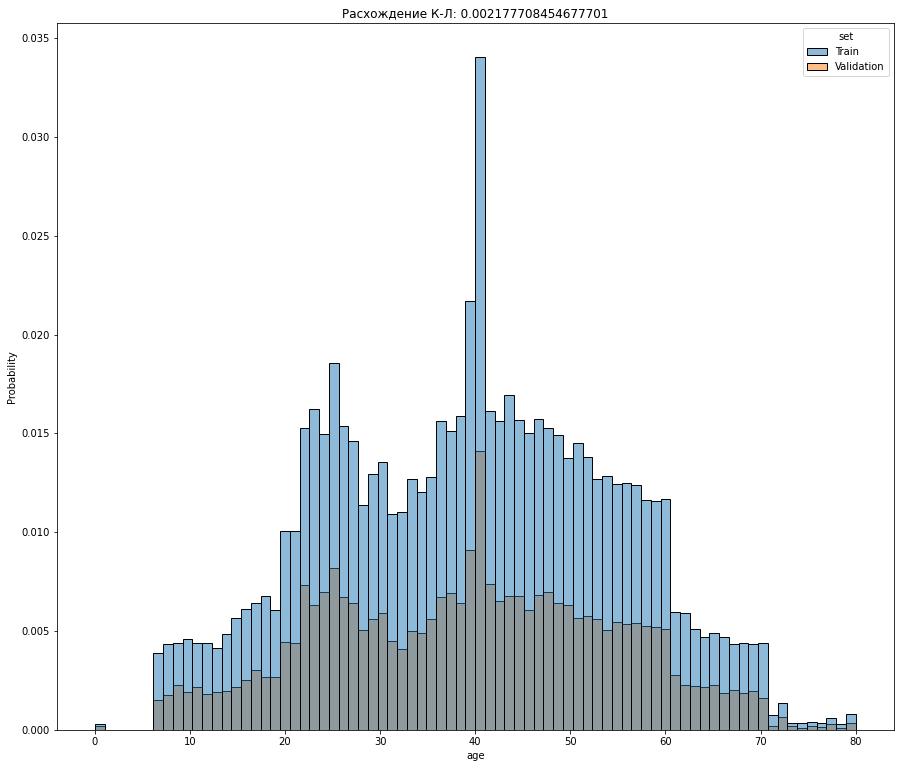

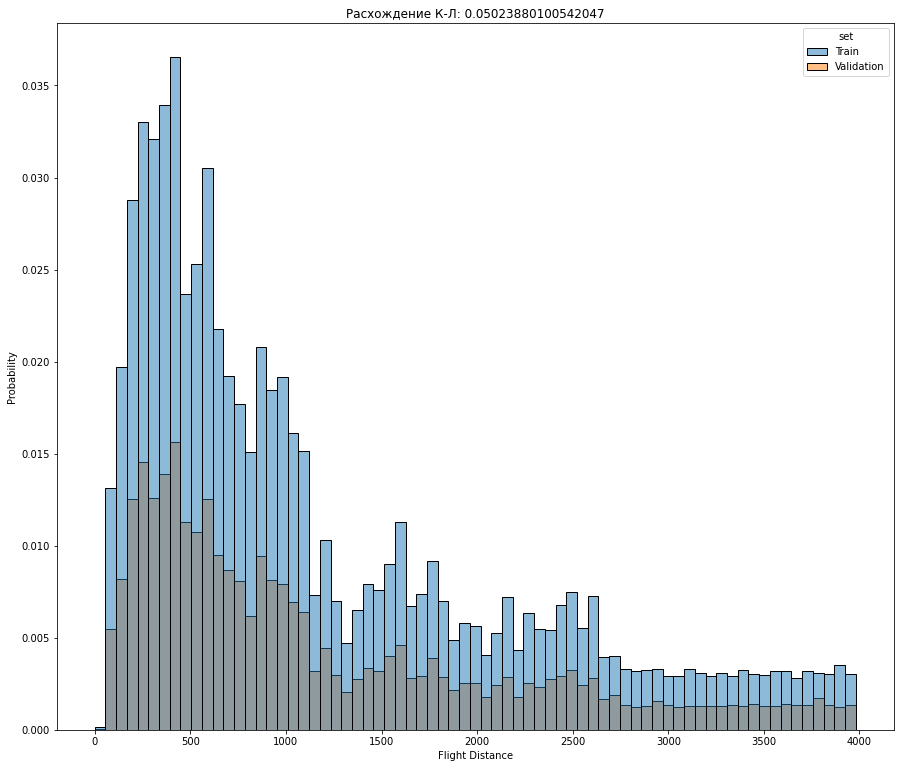

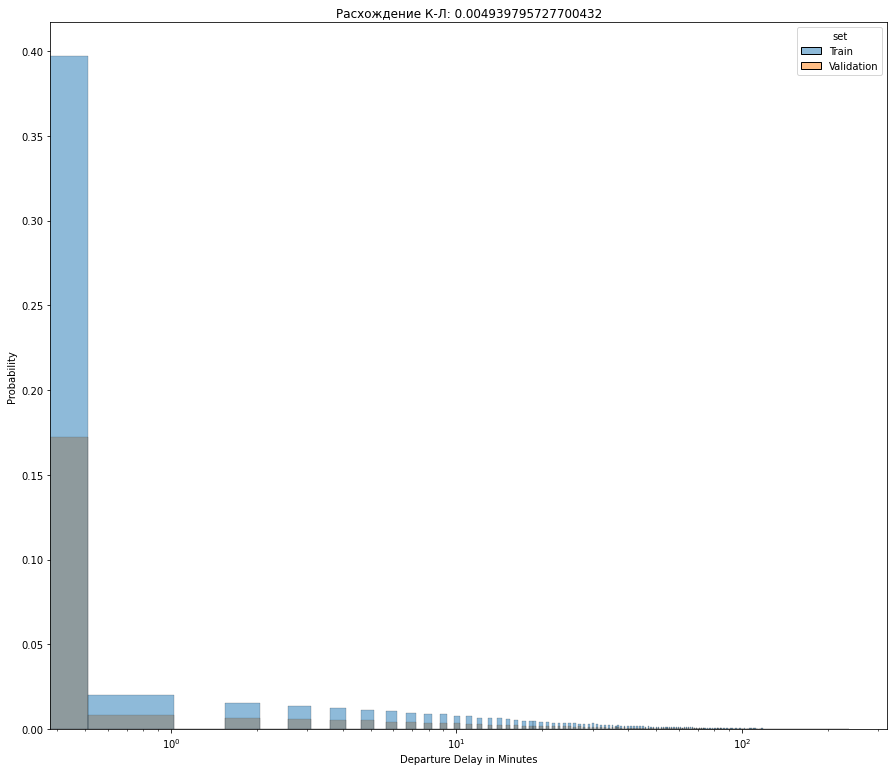

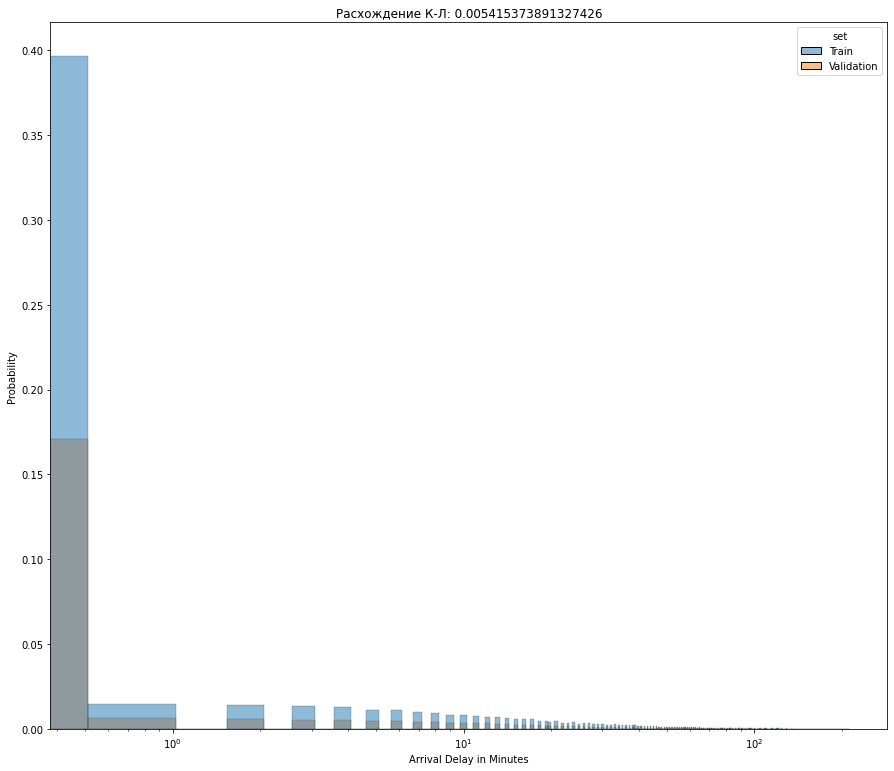

In [43]:
plot_inter_continuous(plot_X, continuous_cols, "set", "Validation")

<Figure size 1080x936 with 0 Axes>

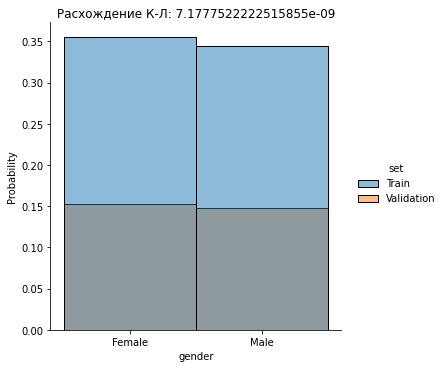

<Figure size 1080x936 with 0 Axes>

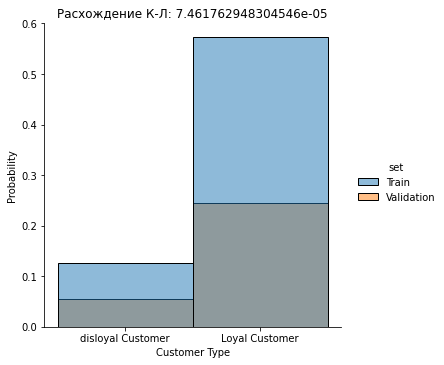

<Figure size 1080x936 with 0 Axes>

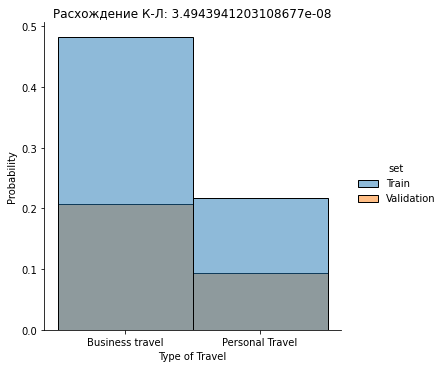

<Figure size 1080x936 with 0 Axes>

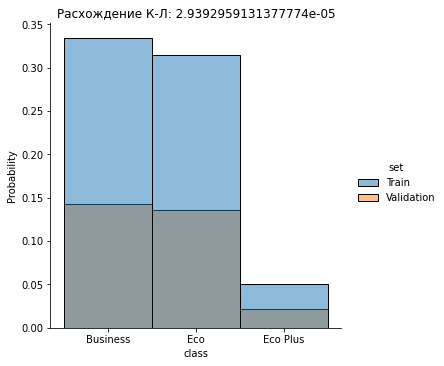

In [44]:
plot_inter_categorical(plot_X, categorical_cols, "set", "Validation")

### Сравнение train и test

In [45]:
plot_x_train = X_train.copy()
plot_x_test = df_test.copy()

plot_x_train["set"] = "Train"
plot_x_test["set"] = "Test"

plot_X = pd.concat([plot_x_train, plot_x_test], axis=0)

<Figure size 1080x936 with 0 Axes>

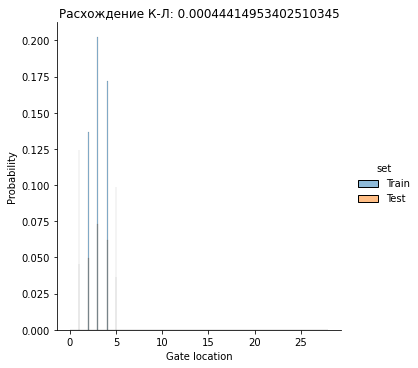

<Figure size 1080x936 with 0 Axes>

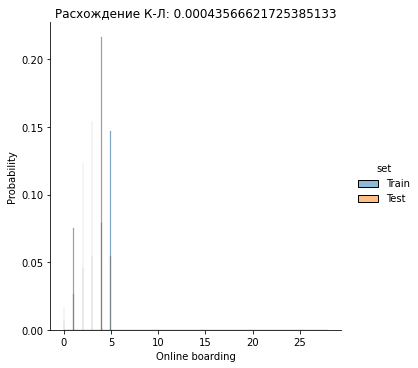

<Figure size 1080x936 with 0 Axes>

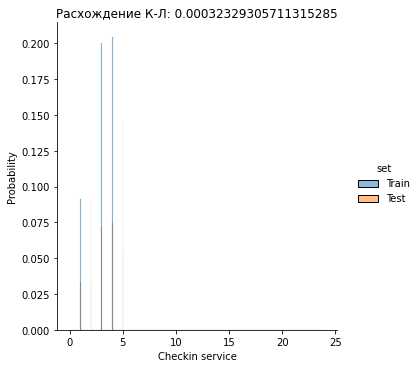

<Figure size 1080x936 with 0 Axes>

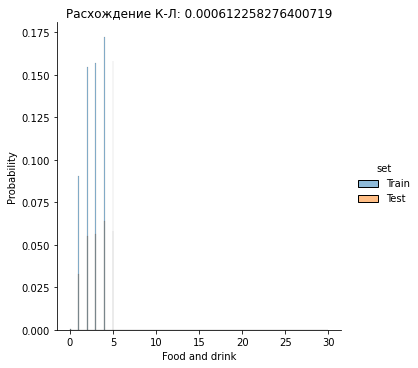

<Figure size 1080x936 with 0 Axes>

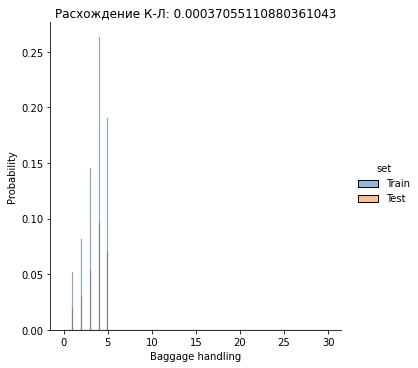

<Figure size 1080x936 with 0 Axes>

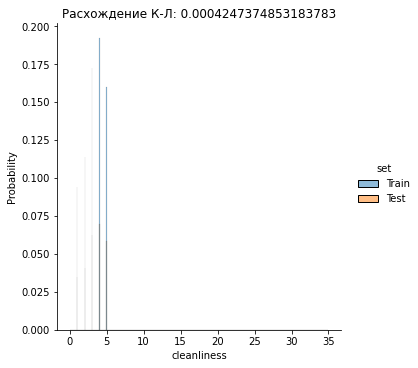

<Figure size 1080x936 with 0 Axes>

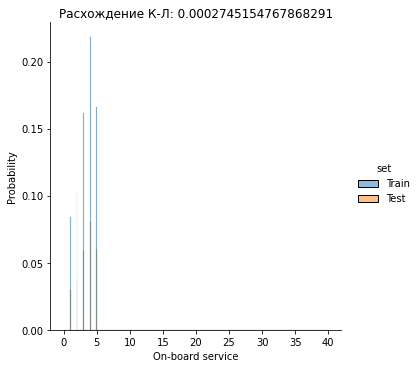

<Figure size 1080x936 with 0 Axes>

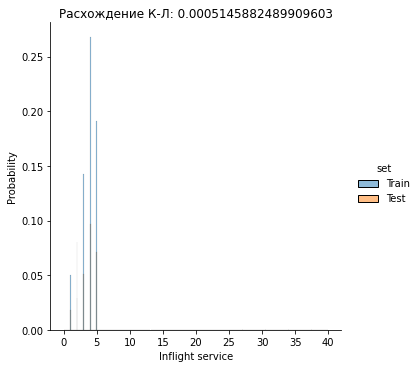

<Figure size 1080x936 with 0 Axes>

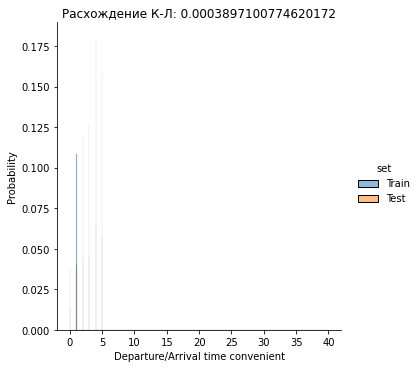

<Figure size 1080x936 with 0 Axes>

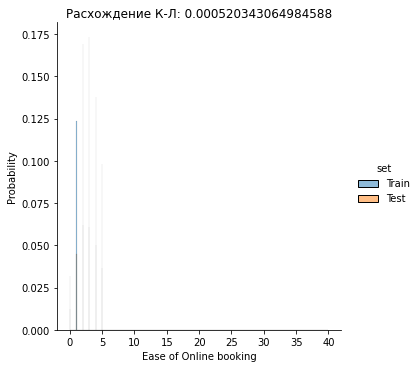

<Figure size 1080x936 with 0 Axes>

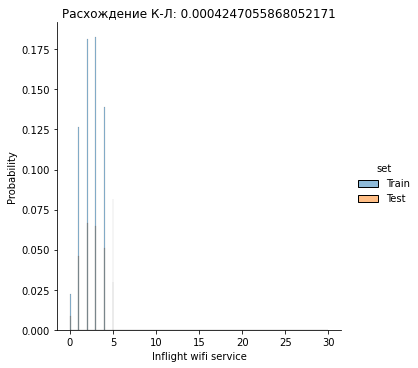

<Figure size 1080x936 with 0 Axes>

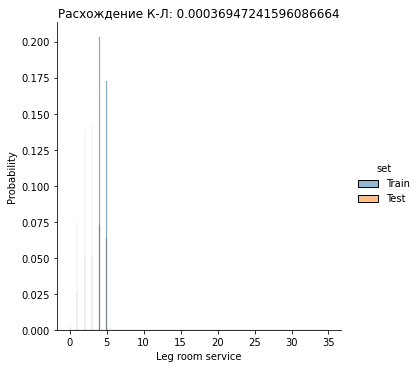

<Figure size 1080x936 with 0 Axes>

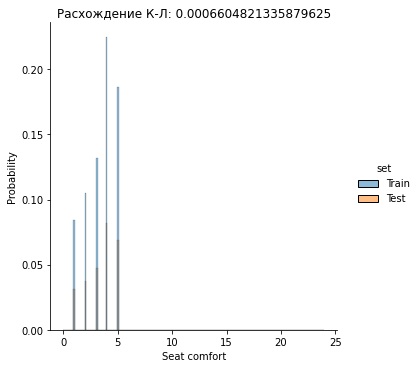

<Figure size 1080x936 with 0 Axes>

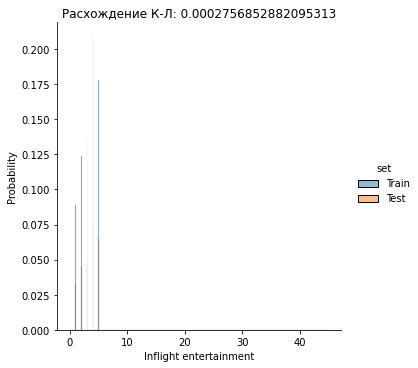

In [46]:
plot_inter_ordinal(plot_X, ordinal_cols, "set", "Test")

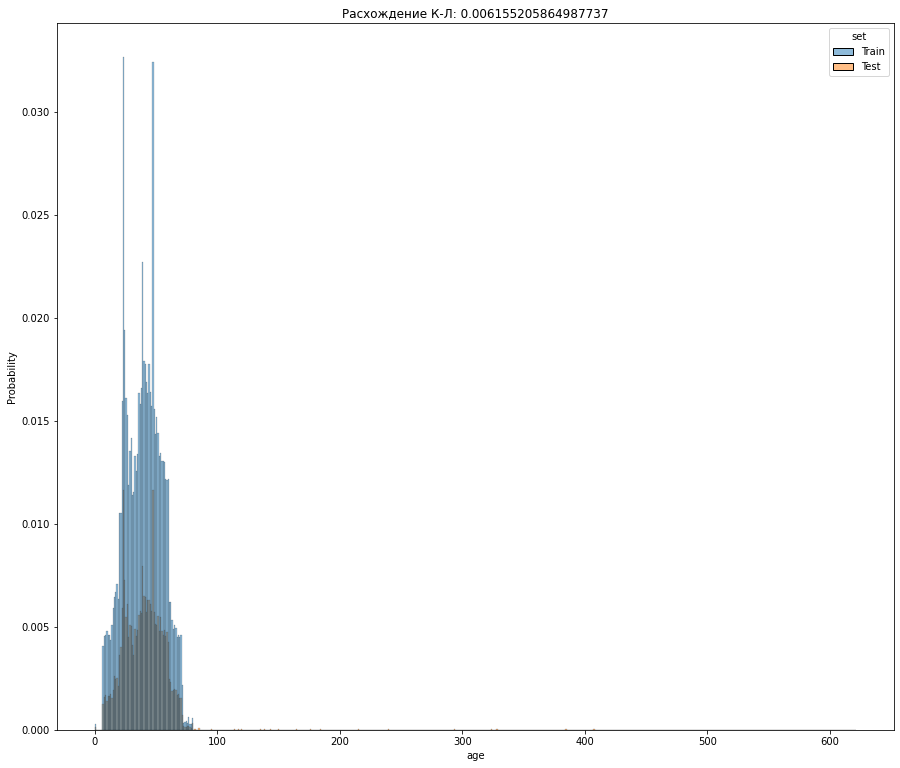

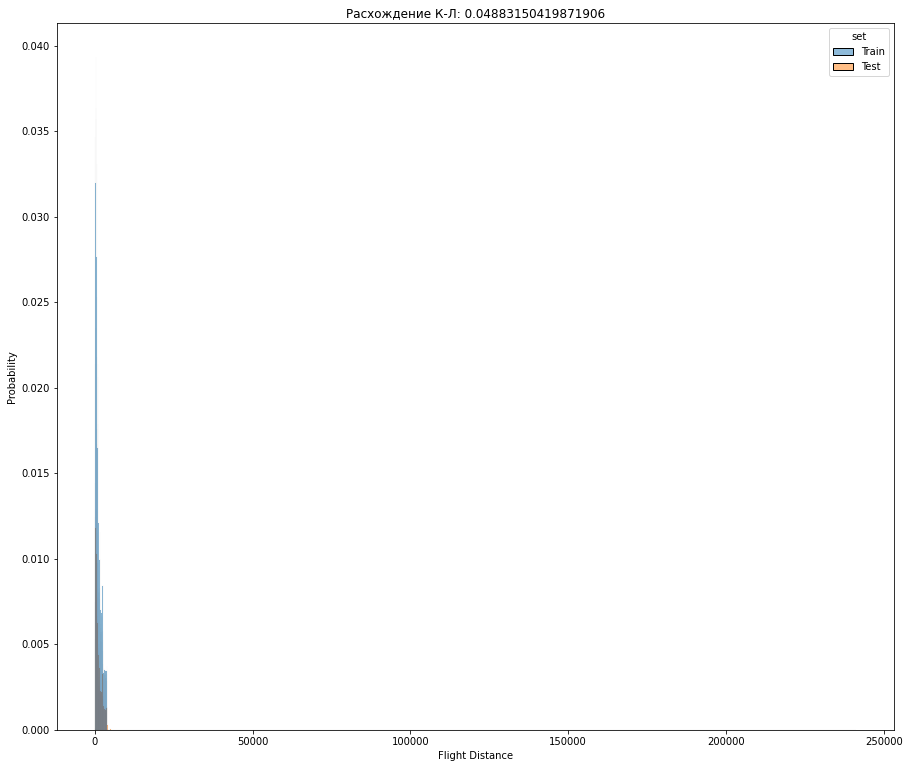

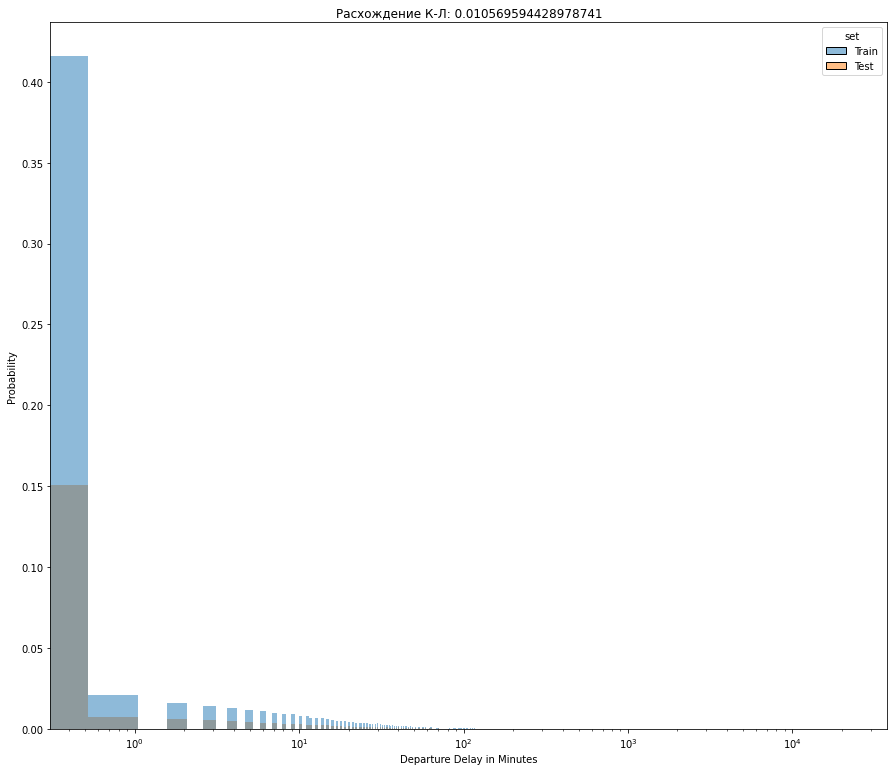

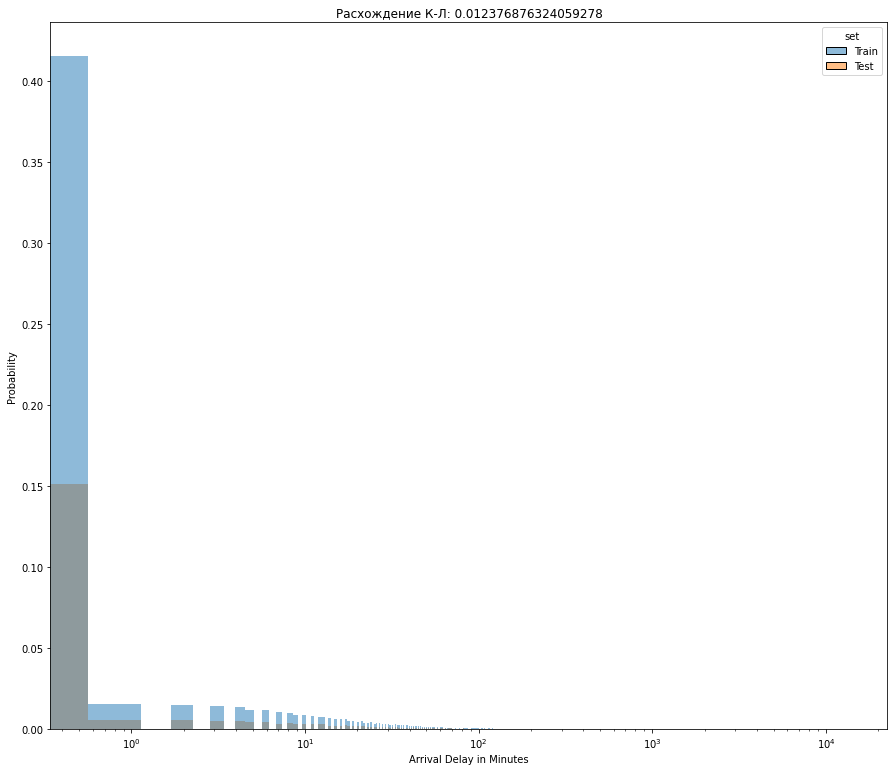

In [47]:
plot_inter_continuous(plot_X, continuous_cols, "set", "Test")

<Figure size 1080x936 with 0 Axes>

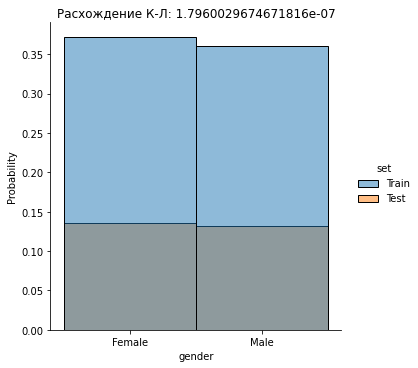

<Figure size 1080x936 with 0 Axes>

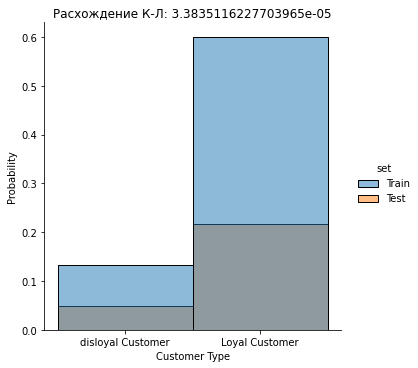

<Figure size 1080x936 with 0 Axes>

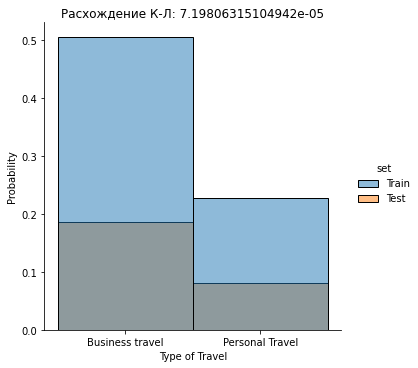

<Figure size 1080x936 with 0 Axes>

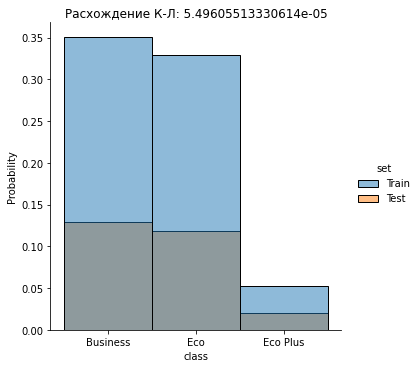

In [48]:
plot_inter_categorical(plot_X, categorical_cols, "set", "Test")

(0.25 балла) Давайте <font color='#9933CC'>заменим признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.</font>

In [158]:
def apply_log(df, col_name):
    temp_series = df[col_name]
    return np.where(temp_series == 0.0, temp_series, np.log(temp_series))

In [159]:
X_train["Departure Delay in Minutes"] = apply_log(X_train, "Departure Delay in Minutes")
X_train["Arrival Delay in Minutes"] = apply_log(X_train, "Arrival Delay in Minutes")

X_val["Departure Delay in Minutes"] = apply_log(X_val, "Departure Delay in Minutes")
X_val["Arrival Delay in Minutes"] = apply_log(X_val, "Arrival Delay in Minutes")

df_test["Departure Delay in Minutes"] = apply_log(df_test, "Departure Delay in Minutes")
df_test["Arrival Delay in Minutes"] = apply_log(df_test, "Arrival Delay in Minutes")

divide by zero encountered in log
invalid value encountered in log


Теперь заново <font color='#9933CC'>постройте графики континуальных признаков</font>

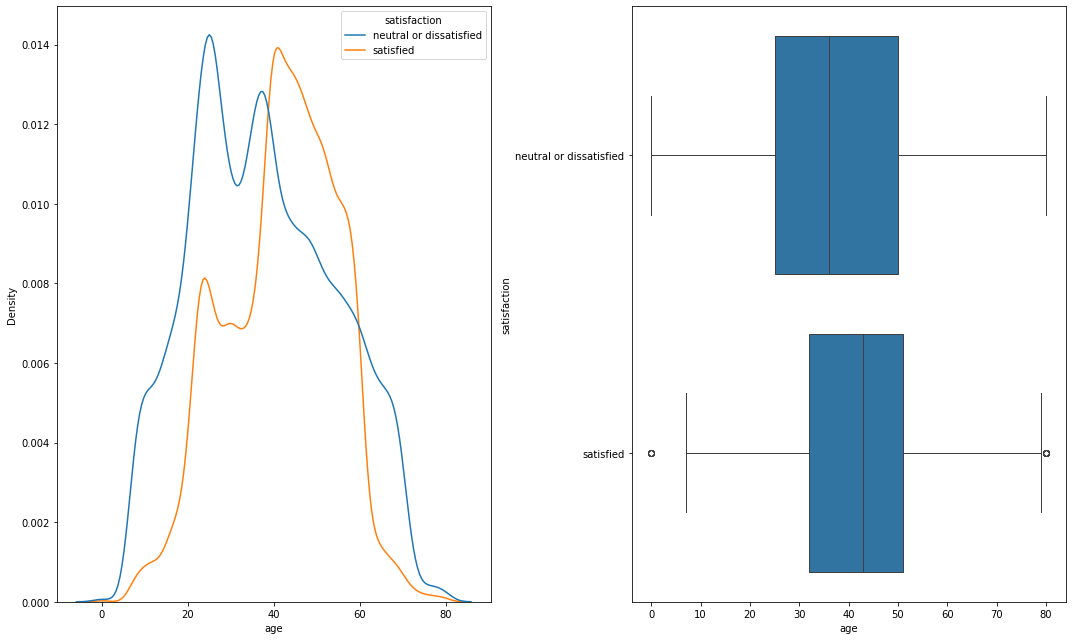

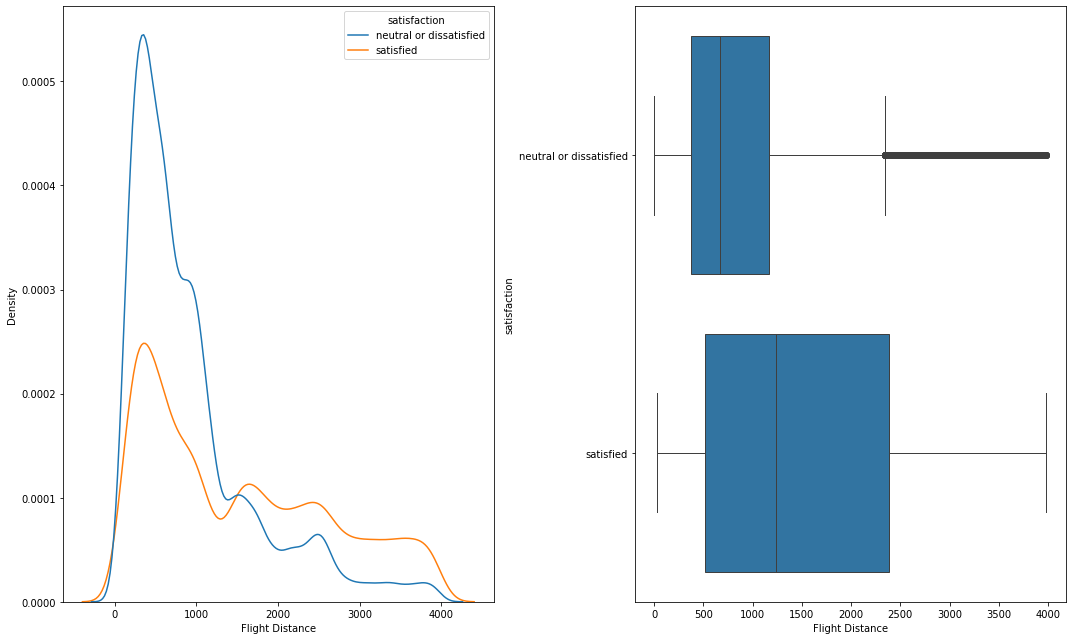

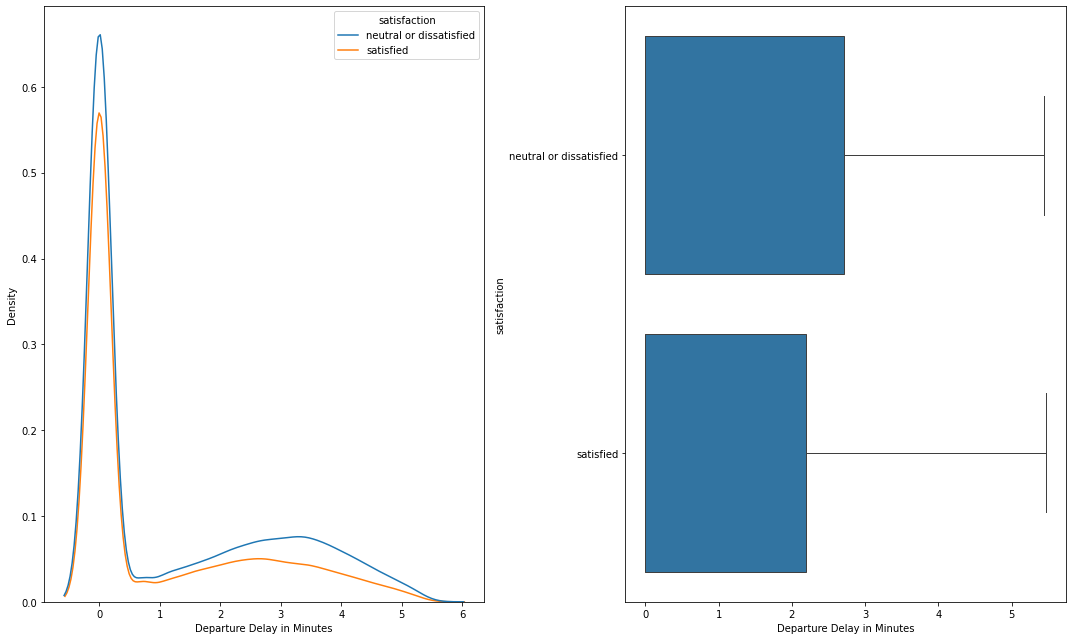

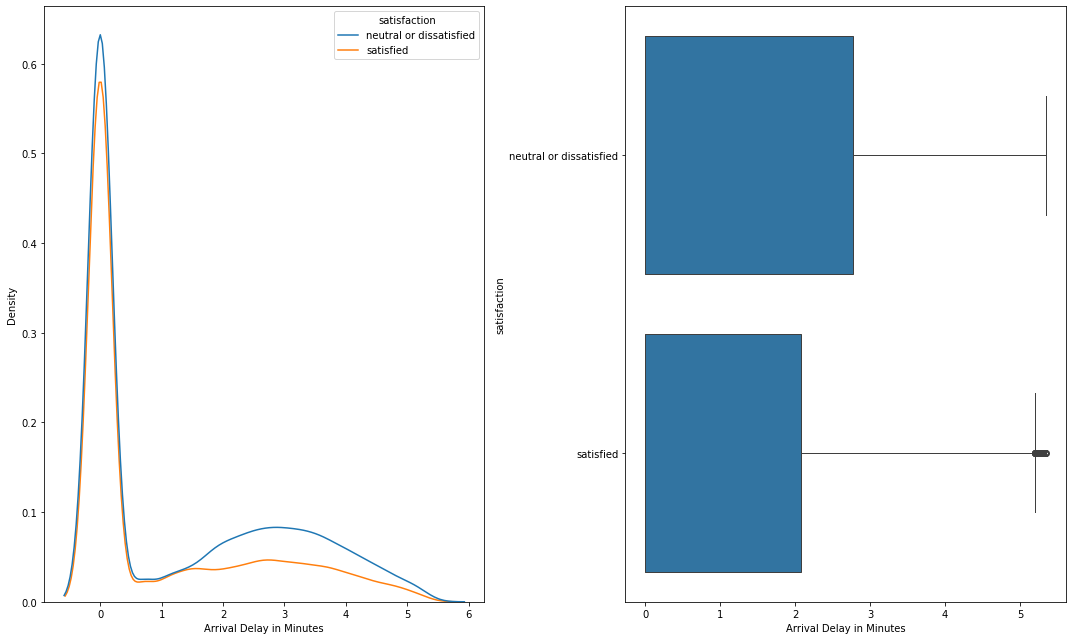

In [160]:
plot_continuous(continuous_cols, X_train, y_train)

<font color='#9933CC'>Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0</font>

In [161]:
y_train.loc[y_train[y_train == "satisfied"].index] = 1
y_train.loc[y_train[y_train == "neutral or dissatisfied"].index] = 0

y_val.loc[y_val[y_val == "satisfied"].index] = 1
y_val.loc[y_val[y_val == "neutral or dissatisfied"].index] = 0

In [162]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)

(0.25 балла) <font color='#9933CC'>Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом</font>. Наблюдений много, так что отрисовка графика вполне может занять несколько минут

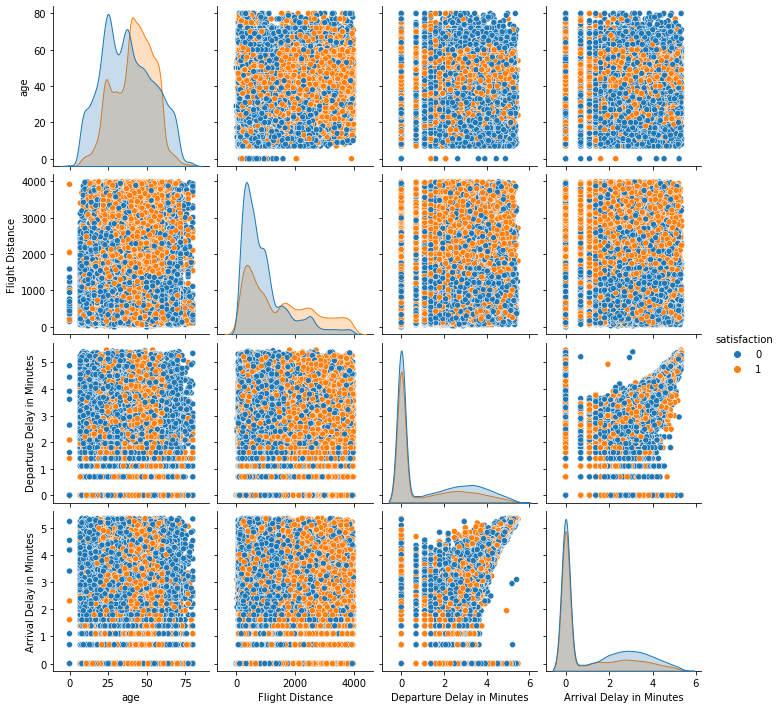

In [429]:
concat_train = pd.concat([X_train[continuous_cols], y_train], axis=1)
sns.pairplot(data=concat_train, hue="satisfaction")

# Decision Tree (3 балла)

(0.5 балла) <font color='#9933CC'>Закодируйте категориальные признаки методом OHE</font>. Для дерева используйте гиперпараметры по умолчанию.

In [163]:
one = OneHotEncoder()
cat_train_one = one.fit_transform(X_train[categorical_cols])
cat_val_one = one.transform(X_val[categorical_cols])

In [164]:
X_train_ohe = pd.concat([X_train[X_train.columns.difference(categorical_cols)].reset_index(drop=True),
                         pd.DataFrame(cat_train_one.toarray(), columns=one.get_feature_names_out())], axis=1)

X_val_ohe = pd.concat([X_val[X_val.columns.difference(categorical_cols)].reset_index(drop=True),
                       pd.DataFrame(cat_val_one.toarray(), columns=one.get_feature_names_out())], axis=1)

<font color='#9933CC'>Обучите дерево решений с параметрами по умолчанию на имеющихся данных.</font> Здесь и далее везде, где вас просят что-нибудь обучить, выводите `accuracy_score` для валидационной подвыборки

In [166]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_ohe, y_train)
print(accuracy_score(y_val, dtc.predict(X_val_ohe)))

0.9448160535117057


## Деревья решений. Теоретическая вставка

(0.5 балла) <font color='#9933CC'>Посчитайте bias и variance для построенного дерева.</font> Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [168]:
error_dt, bias_dt, var_dt = bias_variance_decomp(
        dtc, X_train_ohe.values, y_train.values, X_val_ohe.values, y_val.values, 
        loss='0-1_loss',
        random_seed=42)

error_dt, bias_dt, var_dt

(0.05947422781821759, 0.03928126434520297, 0.043936487638533674)

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>Выведите на экран barplot, демонстрирующий оценки важности признаков</font>

<Axes: >

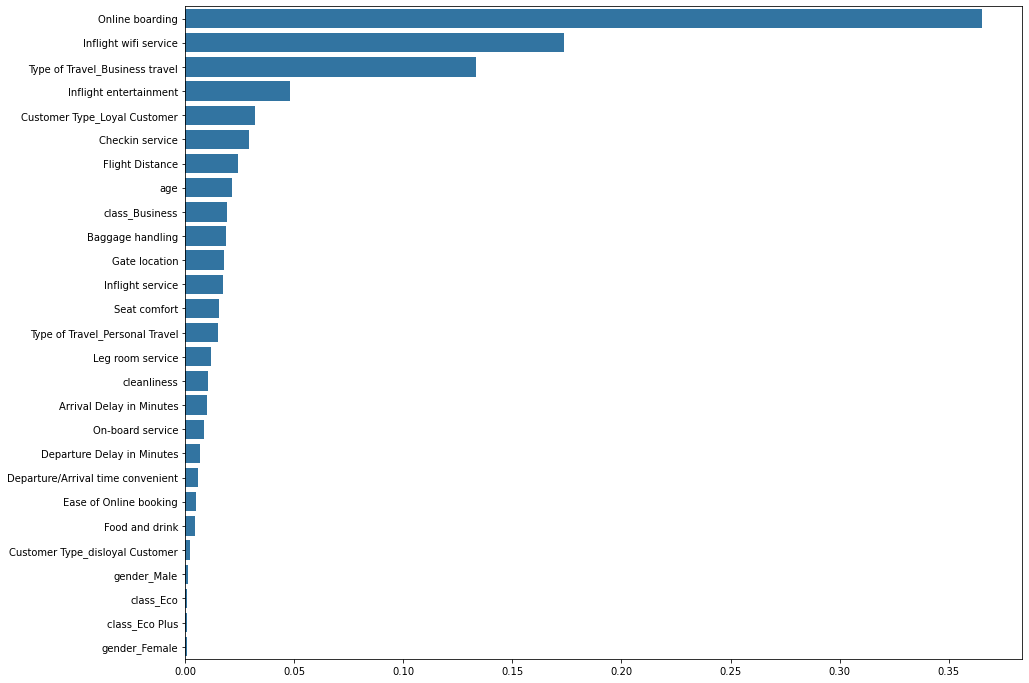

In [211]:
feature_importances = dtc.feature_importances_
feature_names = X_train_ohe.columns
dict_features = dict(zip(feature_names, feature_importances))

plt.figure(figsize=(15, 12))
sns.barplot(dict(sorted(dict_features.items(), key=lambda x: x[1])[::-1]), orient='h')

<font color='#FF6600'>Какие признаки оказались наиболее информативными?</font>

Наиболее информативными оказались: `Online boarding` (оценка онлайн бронирования), `Inflight wifi service` (оценка WIFi на борту), `Type of travel_Business travel` (тип поездки - бизнес), `Inflight enterainment` (оценка разлевлечений)


<font color='#9933CC'>Какой глубины получилось дерево? Сколько в нем листьев?</font>

In [212]:
print(f"Глубина дерева: {dtc.get_depth()}")
print(f"Количество листьев {dtc.get_n_leaves()}")

Глубина дерева: 33
Количество листьев 1991


<font color='#9933CC'>Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева</font>. <font color='#FF6600'>Насколько упало качество на тесте?</font>

In [226]:
top_features_indices = feature_importances.argsort()[-2:][::-1]
X_top2_features_train = X_train_ohe.loc[:, list(feature_names[top_features_indices])]
X_top2_features_val = X_val_ohe.loc[:, list(feature_names[top_features_indices])]

dtc_depth_5 = DecisionTreeClassifier(max_depth=5)

dtc_depth_5.fit(X_top2_features_train, y_train)

print(f'Точность модели с деревом глубиной 5 и двумя наиболее важными признаками: {accuracy_score(y_val, dtc_depth_5.predict(X_top2_features_val))}')

Точность модели с деревом глубиной 5 и двумя наиболее важными признаками: 0.8251032854613417


(0.25 балла) <font color='#9933CC'>С помощью graphviz постройте получившееся дерево решений</font>. <font color='#FF6600'>Почему предикаты в нем не целые, а кратны 1/2?</font>

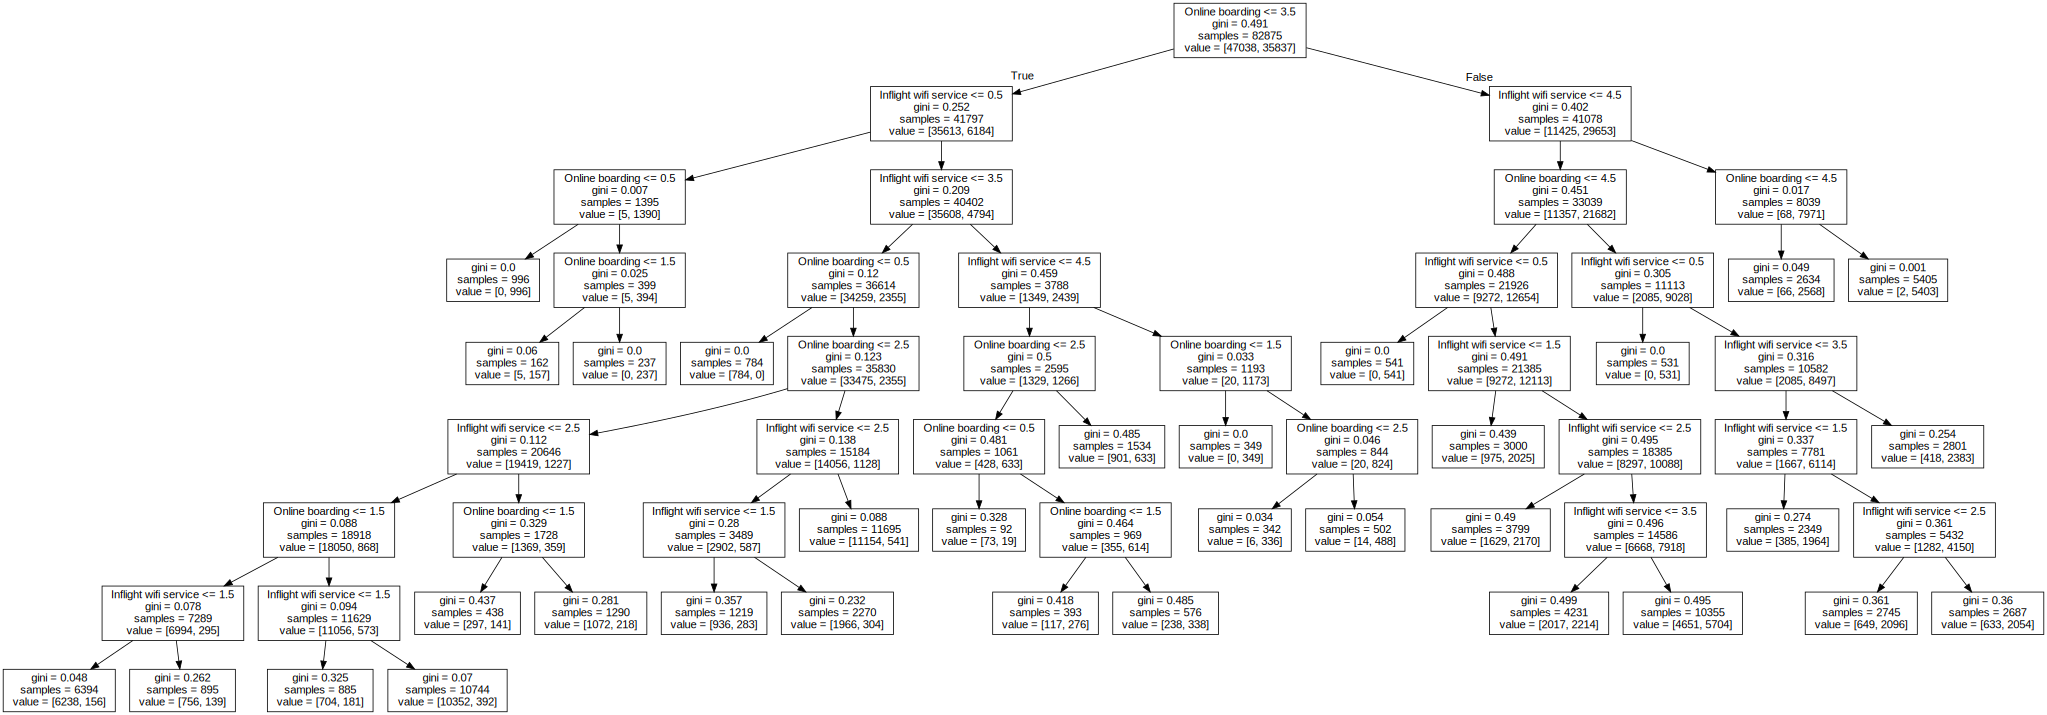

<IPython.core.display.SVG object>

In [259]:
!pip install pydotplus graphviz


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [277]:
from sklearn.tree import export_graphviz
from six import StringIO  
import pydotplus
import graphviz

# Создание объекта StringIO для хранения графа в формате DOT
dot_data = StringIO()

# Экспорт дерева решений в формат DOT
export_graphviz(dtc_depth_5, out_file=dot_data, filled=True, rounded=True, feature_names=list(feature_names[top_features_indices]))

# Создание графа из DOT-данных
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

# Визуализация графа
graph = graphviz.Source(graph, format="svg") 
img = Image.open(graph.pipe())
img.show()

ExecutableNotFound: ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [257]:
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
import io

# Создание объекта StringIO для хранения графа в формате DOT
dot_data = io.BytesIO()

# Экспорт дерева решений в формат DOT
export_graphviz(dtc_depth_5, out_file=dot_data, filled=True, rounded=True, feature_names=list(feature_names[top_features_indices]))

# Создание графа из DOT-данных
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

# Визуализация графа
Image(graph.create_png())

TypeError: TypeError: a bytes-like object is required, not 'str'

<font color='#9933CC'>Теперь постройте дерево той же глубины 5 для 2-х наиболее информативных континуальных (по договорённости) признаков</font>

In [304]:
top_features = list(feature_names[feature_importances.argsort()[::-1]])
top2_continuos = [f for f in top_features if f in continuous_cols][:2] 
X_top2_features_train = X_train_ohe.loc[:, top2_continuos]
X_top2_features_val = X_val_ohe.loc[:, top2_continuos]

dtc_depth_5 = DecisionTreeClassifier(max_depth=5)

dtc_depth_5.fit(X_top2_features_train, y_train)

print(f'Точность модели с деревом глубиной 5 и двумя наиболее важными континуальными признаками: {accuracy_score(y_val, dtc_depth_5.predict(X_top2_features_val))}')

Точность модели с деревом глубиной 5 и двумя наиболее важными континуальными признаками: 0.6835530198701554


(0.25 балла) <font color='#9933CC'>Отобразите его функцией `plot_tree()` из sklearn</font>. <font color='#FF6600'>Симметричным ли получилось дерево? Это хорошо или плохо?</font>

In [314]:
from IPython.display import Image

# Image("/data/notebook_files/dtc_depth_5_continous.svg")
plt.figure(figsize=(55, 42), dpi=300)
plot_tree(dtc_depth_5)
plt.savefig("dtc_depth_5_continous.png", format="png")

ValueError: ValueError: Cannot embed the 'svg' image format

(0.5 балла) <font color='#9933CC'>Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева.</font> Отметьте на графике только первые 100 объектов обучающей выборки

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names




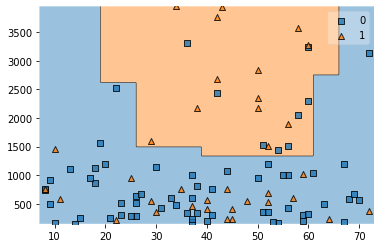

<Figure size 432x288 with 1 Axes>

In [51]:
# your line of code

## Деревья решений. Теоретическая вставка 2

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



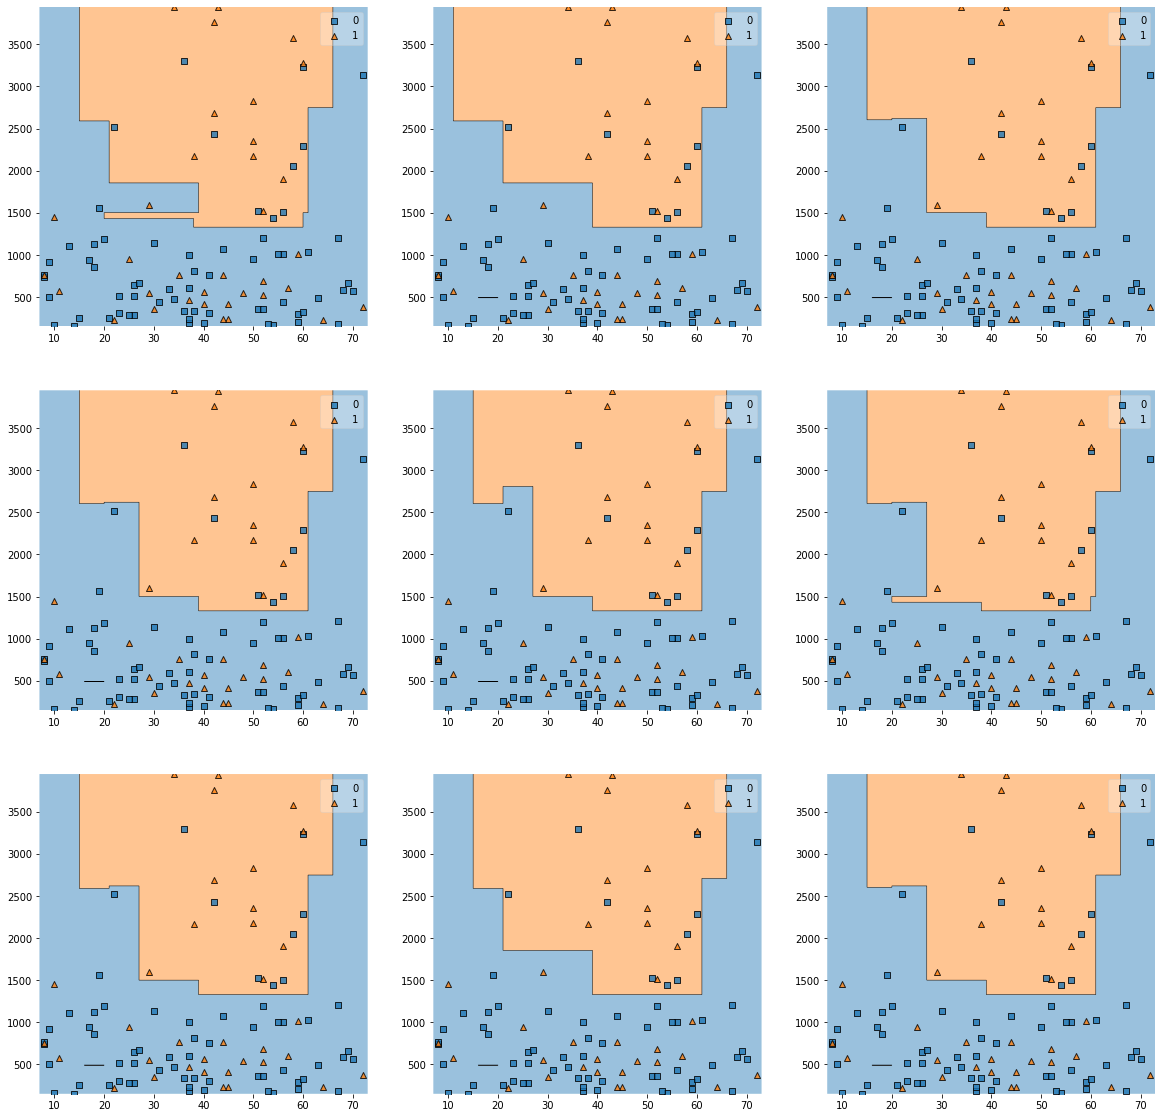

<Figure size 1440x1440 with 9 Axes>

In [ ]:
# change X_train_example to your equivalent

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

Мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
# change X_train_enc into your ohe-encoded train set

%%time 
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

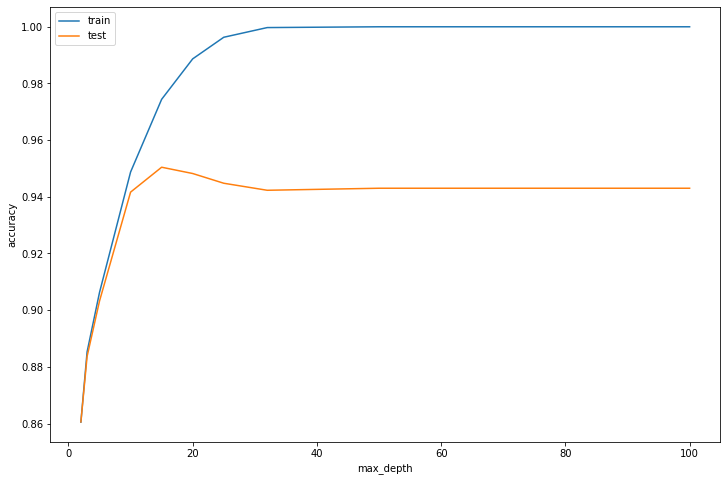

<Figure size 864x576 with 1 Axes>

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>На кроссвалидации подберите оптимальные гиперпараметры для дерева решений</font> *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*. <font color='#FF6600'>Удалось ли улучшить качество предсказаний подбором гиперпараметров?</font>

In [ ]:
# you know what to do


<font color='#9933CC'> Сохраните лучшее дерево в pickle </font>

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('DT.pkl', 'wb') as f:
    pass

# Random Forest (4 балла)

<font color='#9933CC'>Обучите случайный лес с параметрами по умолчанию</font>

In [ ]:
# -__-


(0.75 балла) <font color='#9933CC'>Выведите калибровочную кривую для полученного ансамбля</font>

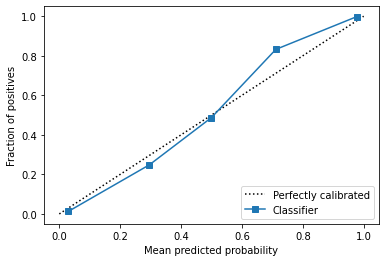

<Figure size 432x288 with 1 Axes>

In [123]:
# some lines of your code


Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

<font color='#FF6600'>Вспомните (или выведите), корректно ли деревья предсказывают вероятности?</font>

In [ ]:
# your answer below
# feel free to change this cell into markdown


<font color='#9933CC'>Обучите логистическую регрессию с параметрами по умолчанию и отобразите её калибровочную кривую</font>

UPD: не с параметрами по умолчанию, а так, чтоб сошлась

CPU times: user 530 ms, sys: 278 ms, total: 808 ms
Wall time: 431 ms




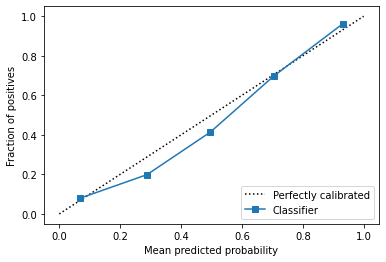

<Figure size 432x288 with 1 Axes>

In [124]:
# --____--


Мы немного переоцениваем предсказанные низкие вероятности

<font color='#FF6600'>Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?</font>

In [ ]:
# maths needed


(0.75 балла) <font color='#9933CC'>Предлагаем вам попробовать откалибровать вероятности обученного случайного леса</font>. Для этого воспользуйтесь логистической и изотонической регрессиями. <font color='#FF6600'>Интерпретируйте полученные результаты</font>

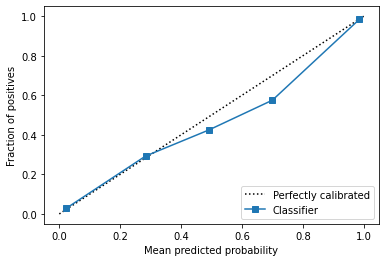

<Figure size 432x288 with 1 Axes>

In [125]:
# yet another code cell for logreg


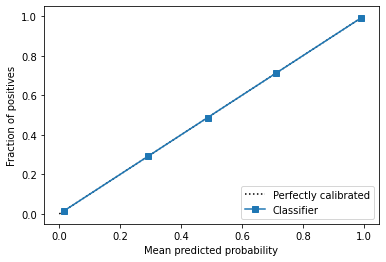

<Figure size 432x288 with 1 Axes>

In [126]:
# yet another code cell for isoreg


<font color='#FF6600'>Опишите другие возвожные подходы к калбировке вероятностей (со ссылками на источники)</font>

In [ ]:
# feel free to change this cell into markdown


(1 балл) <font color='#9933CC'>Посчитайте разброс и смещение полученного случайного леса (до калибровки).</font><font color='#FF6600'>Оличаются ли они от полученных для дерева решений? Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?</font>

In [ ]:
# one more place for your code


<font color='#9933CC'>Вычислите разложение ошибки для логистической регрессии (ванильной, не той, что использовали для калибровки).</font> <font color='#FF6600'>Сравните полученные результаты с предыдущими. Объясните природу этих результатов</font>

In [ ]:
# (•_•)

(1 балл) <font color='#9933CC'>Попробуйте подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`</font>. Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
# your code here


## Случайный лес. Вставка теории

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# change X_train_enc into you equivalent

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


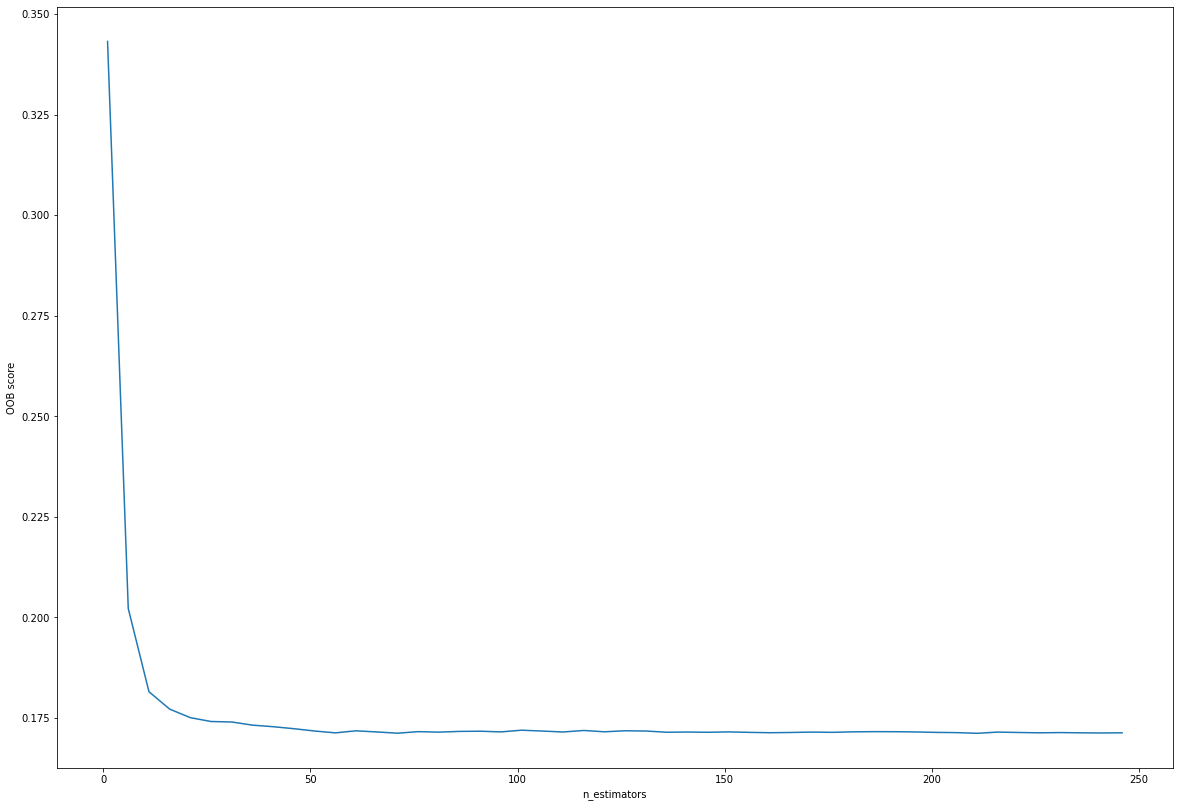

<Figure size 1440x1008 with 1 Axes>

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

> **Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной 

## Возвращение к задаче

<font color='#9933CC'>Отобразите `feature_importances_` вашего лучшего случайного леса</font>

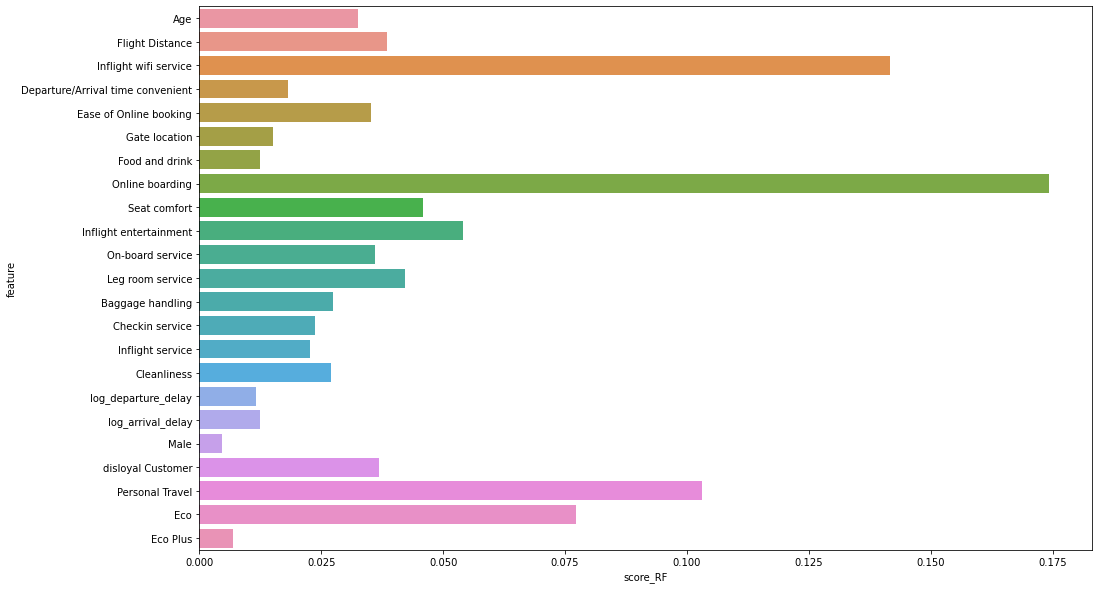

<Figure size 1152x720 with 1 Axes>

In [ ]:
# (•_•)

(0.5 балла) <font color='#9933CC'>Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму</font>

In [ ]:
# -__-

Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре


CPU times: user 5min 45s, sys: 2.77 s, total: 5min 47s
Wall time: 5min 45s


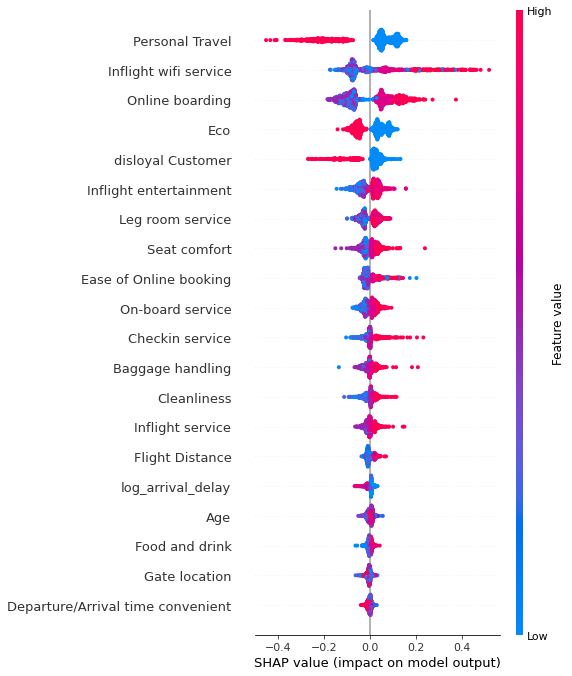

<Figure size 576x684 with 2 Axes>

In [ ]:
# (•_•)

<font color='#FF6600'>Опишите полученый график</font>

In [ ]:
# your explanation below

<font color='#FF6600'>Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется? </font>

In [ ]:
# feel free to change this cell into markdown


Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью LIME</font>

In [ ]:
# please type your solution below




CPU times: user 13 s, sys: 918 ms, total: 13.9 s
Wall time: 16.1 s


X does not have valid feature names, but RandomForestClassifier was fitted with feature names




<IPython.core.display.HTML object>

<font color='#FF6600'>Опишите полученый график</font>

In [ ]:
# your explanation below

<font color='#9933CC'>Случайное лес, дающий лучший скор, сохраните в pickle</font>

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?